## Setup Env: Run this before you start

In [ ]:
#### pip & Data & license file

!pip3 install gurobipy
!pip install gdown

# Check for optional dependencies
try:
    import matplotlib_venn
    VENN_AVAILABLE = True
except ImportError:
    VENN_AVAILABLE = False
    print("matplotlib_venn not available. Install with 'pip install matplotlib-venn' for enhanced visualization.")

In [ ]:
#### Download all dataset, (Andrew's personal academic) license

In [ ]:
# Download all ambulance dataset. It will take some time. Depends on your network but about 3 min.
!gdown --folder https://drive.google.com/drive/folders/11Tx0kHH_8YVdTqHarfuBpTxGyN0JlLan

### When you have issue with the below code, access the upper google drive link and paste the "gurobi.lic" to "data" folder

In [25]:
# License
license_path = "data/gurobi.lic"

params = {}
with open(license_path, 'r') as file:
    for line in file:
        if '=' in line:
            key, value = line.strip().split('=')
            if key == 'LICENSEID':
                params[key] = int(value)  # Convert LICENSEID to int
            else:
                params[key] = value

# Check that it worked
print(params)

{'WLSACCESSID': '5cec81c9-a70e-4689-9487-28f5a1553f93', 'WLSSECRET': 'b583cde1-579c-4eb4-807e-d13bbe6446d7', 'LICENSEID': 2659300}


In [26]:
#### Dependencies

import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
import networkx as nx
import time
import itertools
from collections import defaultdict
import math
import os
import pickle
import glob

# Gurobi

## Start Gurobi Session

In [27]:
env = gp.Env(params=params)
model = gp.Model(env=env)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu


## Gurobi Test Example

In [28]:
x = model.addVar(name="x")
y = model.addVar(name="y")

model.setObjective(x + y, gp.GRB.MAXIMIZE)
model.addConstr(x + 2*y <= 4, "c0")
model.addConstr(4*x + 2*y <= 12, "c1")

model.optimize()

for v in model.getVars():
    print(f'{v.varName} = {v.x}')

Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2 rows, 2 columns and 4 nonzeros
Model fingerprint: 0xe530171d
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+01]
Presolve time: 0.00s
Presolved: 2 rows, 2 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.5000000e+30   3.250000e+30   1.500000e+00      0s
       2    3.3333333e+00   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.333333333e+00
x = 2.6666666666666665
y = 0.6666666666666666


## VERY IMPORTANT : DISPOSE MODEL EVERYTIME

In [29]:
# After running Gurobi modle, YOU SHOULD ALWAYS PUT THIS TO END THE SESSION. THERE IS SESSION LIMITATION THAT CAN RUN SIMULTANEOUSLY

model.dispose()
env.dispose()

# Step0.A: Data Preparation

In [30]:
# Path to the dataset
DATA_DIR = "./data/50"
T_periods = 6  # you can set this manually or detect later if embedded

# Collect all .gpickle files in the folder
gpickle_files = [f for f in os.listdir(DATA_DIR) if f.endswith(".gpickle")]
print(f"Found {len(gpickle_files)} instances in {DATA_DIR}")

Found 5 instances in ./data/50


In [31]:
# Loop through each file and load the graph
for g_file in gpickle_files:
    file_path = os.path.join(DATA_DIR, g_file)

    with open(file_path, 'rb') as f:
        G = pickle.load(f)

    if not isinstance(G, nx.Graph):
        print(f"{g_file}: ❌ Not a valid NetworkX graph.")
        continue

    n_areas = G.number_of_nodes()
    adjacency_matrix = nx.to_numpy_array(G)

    print(f"{g_file} → Nodes: {n_areas}, Adjacency matrix shape: {adjacency_matrix.shape}")

50-3557-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-4606-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-9085-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-3389-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)
50-3004-6-7-35.gpickle → Nodes: 50, Adjacency matrix shape: (50, 50)


# Step0.B: Extract the neighbor relationships from each graph instance

In [ ]:
for g_file in gpickle_files:
    base_file = g_file.replace(".gpickle", ".bases")
    gpickle_path = os.path.join(DATA_DIR, g_file)
    base_path = os.path.join(DATA_DIR, base_file)

    print(f"\n🔍 Processing {g_file}")

    # Load the graph
    with open(gpickle_path, 'rb') as f:
        G = pickle.load(f)

    if not isinstance(G, nx.Graph):
        print(f"{g_file}: ❌ Not a valid graph.")
        continue

    # Extract all node labels (which are coordinate tuples)
    node_coords = list(G.nodes)

    # Load base coordinates from .bases file (as tuples)
    base_coords = []
    with open(base_path, 'r') as f:
        for line in f:
            if line.strip():
                coord = eval(line.strip())  # assumes format: (x, y)
                base_coords.append(coord)

    # Check which graph nodes match the base coordinates exactly
    base_nodes = [node for node in G.nodes if node in base_coords]
    print(f"🚑 Base nodes matched: {base_nodes}")

    # Color base nodes red, others light blue
    color_map = ['red' if node in base_nodes else 'lightblue' for node in G.nodes]

    # Build layout: use node coordinates as positions
    pos = {node: node for node in G.nodes}  # position = node coordinate

    # Draw the graph
    plt.figure(figsize=(7, 5))
    nx.draw(
        G, pos,
        with_labels=False,
        node_color=color_map,
        node_size=100,
        edge_color='gray',
    )
    plt.title(f"{g_file} (Red = Bases)", fontsize=10)
    plt.axis('off')
    plt.show()

# Step0.C: Generate All Valid Ambulance Paths (“Configurations”) = Column Generation

In [32]:
# Step 0.C: Generate All Valid Ambulance Allocations ("Configurations")
# REVISED: Generate all possible ways to allocate ambulances across bases

import itertools
import os
import pickle
import pandas as pd

# --- SETTINGS ---
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
T = 6
NUM_AMBULANCES = 35
OUTPUT_DIR = f"configurations/50/{FILENAME}_allocations"

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

# For each base, we need to generate all possible ambulance counts
# Each configuration is a tuple: (num_ambulances_at_base1, num_ambulances_at_base2, ...)
# Such that the sum equals NUM_AMBULANCES

print(f"Number of bases: {len(base_coords)}")
print(f"Total ambulances to allocate: {NUM_AMBULANCES}")
print(f"Generating all possible allocations...")

# Generate all combinations using stars and bars approach
# We need to distribute NUM_AMBULANCES across len(base_coords) bases
def generate_allocations(total_ambulances, num_bases):
    """Generate all possible ways to allocate total_ambulances across num_bases"""
    if num_bases == 1:
        return [(total_ambulances,)]
    
    allocations = []
    for first_base_count in range(total_ambulances + 1):
        remaining_ambulances = total_ambulances - first_base_count
        remaining_bases = num_bases - 1
        
        sub_allocations = generate_allocations(remaining_ambulances, remaining_bases)
        for sub_allocation in sub_allocations:
            allocation = (first_base_count,) + sub_allocation
            allocations.append(allocation)
    
    return allocations

# Generate all possible allocations
configurations = generate_allocations(NUM_AMBULANCES, len(base_coords))

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Save configurations
with open(os.path.join(OUTPUT_DIR, "configurations.pkl"), "wb") as f:
    pickle.dump(configurations, f)

# Create DataFrame with proper column names
df_data = []
for cfg_idx, config in enumerate(configurations):
    row = [cfg_idx] + list(config)
    df_data.append(row)

columns = ["config_id"] + [f"base{i}_ambulances" for i in range(len(base_coords))]
df = pd.DataFrame(df_data, columns=columns)
df.to_csv(os.path.join(OUTPUT_DIR, "configurations.csv"), index=False)

print(f"\n✅ Generated {len(configurations)} configurations")
print(f"✅ Saved to {OUTPUT_DIR}")

# Show first 10 configurations as examples
print("\n=== First 10 configurations ===")
print(df.head(10).to_string(index=False))

# Verify the sum constraint
print("\n=== Verification ===")
for idx, row in df.head(5).iterrows():
    total = sum(row[f"base{i}_ambulances"] for i in range(len(base_coords)))
    print(f"Config {row['config_id']}: total ambulances = {total} (should be {NUM_AMBULANCES})")

# Calculate and display statistics
total_configs = len(configurations)
print(f"\n=== Statistics ===")
print(f"Total number of configurations: {total_configs:,}")
print(f"Maximum ambulances per base: {max(max(config) for config in configurations)}")
print(f"Average ambulances per base: {NUM_AMBULANCES / len(base_coords):.2f}")

# Calculate using stars and bars formula for verification
import math
expected_configs = math.comb(NUM_AMBULANCES + len(base_coords) - 1, len(base_coords) - 1)
print(f"Expected configurations (stars and bars): {expected_configs:,}")
print(f"Generated == Expected: {total_configs == expected_configs}")

# Create a visualization of allocation patterns
import matplotlib.pyplot as plt

# Plot first few configurations
fig, ax = plt.subplots(figsize=(12, 8))
for i, config in enumerate(configurations[:10]):  # First 10 configs
    ax.bar(range(len(base_coords)), config, alpha=0.7, label=f'Config {i}')

ax.set_xlabel('Base Index')
ax.set_ylabel('Number of Ambulances')
ax.set_title('Ambulance Allocation Patterns (First 10 Configurations)')
ax.set_xticks(range(len(base_coords)))
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "allocation_patterns.png"), dpi=300, bbox_inches='tight')
plt.close()

# Create histogram of ambulance distribution
allocation_counts = []
for config in configurations:
    allocation_counts.extend(config)

plt.figure(figsize=(10, 6))
plt.hist(allocation_counts, bins=range(max(allocation_counts)+2), align='left', rwidth=0.8)
plt.xlabel('Number of Ambulances')
plt.ylabel('Frequency')
plt.title('Distribution of Ambulance Counts Across All Configurations')
plt.xticks(range(max(allocation_counts)+1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "ambulance_distribution.png"), dpi=300, bbox_inches='tight')
plt.close()

print(f"\n✅ Visualizations saved to {OUTPUT_DIR}")

Number of bases: 5
Total ambulances to allocate: 35
Generating all possible allocations...

✅ Generated 82251 configurations
✅ Saved to configurations/50/50-3004-6-7-35_allocations

=== First 10 configurations ===
 config_id  base0_ambulances  base1_ambulances  base2_ambulances  base3_ambulances  base4_ambulances
         0                 0                 0                 0                 0                35
         1                 0                 0                 0                 1                34
         2                 0                 0                 0                 2                33
         3                 0                 0                 0                 3                32
         4                 0                 0                 0                 4                31
         5                 0                 0                 0                 5                30
         6                 0                 0                 0               

# STEP 1.A >>> Run experiments on a small dataset - Compare different batches of configurations and show how the fairness changes 

#### Master Problem ILP construction (Configuration-based / TESTING before batch processing : only 100 configs)

### STEP 1.A - 1 >>> Optimization and Data Collection

In [33]:
# --- SETTINGS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Create the results directory structure
results_dir = "results/Step1A"
os.makedirs(results_dir, exist_ok=True)

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

# Create zone/base numbering for simplified labels
zone_to_num = {zone: i+1 for i, zone in enumerate(zones)}
num_to_zone = {i+1: zone for i, zone in enumerate(zones)}
base_to_num = {base: i+1 for i, base in enumerate(base_coords)}

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# --- TEST WITH DIFFERENT BATCH SIZES ---
batch_sizes = [10, 100, 1000, 10000]
results = []
zone_coverage_details = []

# Main optimization loop for different batch sizes
for batch_size in batch_sizes:
    print(f"\n{'='*60}")
    print(f"Testing with {batch_size} configurations")
    print(f"{'='*60}")
    
    # Reload environment for each batch
    env = gp.Env(params=params)
    model = gp.Model(env=env)
    
    # --- LOAD CONFIGURATIONS ---
    df = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv")).head(batch_size)
    configurations = []
    for _, row in df.iterrows():
        config = []
        for i in range(len(base_coords)):
            config.append(int(row[f"base{i}_ambulances"]))
        configurations.append(tuple(config))
    
    print(f"First 5 configurations:")
    for i, cfg in enumerate(configurations[:5]):
        print(f"  Config {i}: {cfg}")
    
    # --- BUILD COVERAGE MATRIX b[i,t,c] ---
    b = {}
    for c_idx, config in enumerate(configurations):
        for base_idx, num_ambulances in enumerate(config):
            if num_ambulances > 0:
                base_zone = base_coords[base_idx]
                coverage = {base_zone} | adjacency.get(base_zone, set())
                for t in range(T):
                    for z in coverage:
                        b[(z, t, c_idx)] = 1
    
    # --- MODEL VARIABLES ---
    λ = model.addVars(len(configurations), vtype=GRB.BINARY, name="lambda")
    y = model.addVars(zones, vtype=GRB.INTEGER, name="y")
    z = model.addVar(vtype=GRB.INTEGER, name="z")
    
    # --- CONSTRAINTS ---
    # 1. Select exactly 1 configuration
    model.addConstr(gp.quicksum(λ[c] for c in range(len(configurations))) == 1, "select_one_config")
    
    # 2. Define y_i = total coverage for each zone
    for i in zones:
        model.addConstr(
            y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(len(configurations)) for t in range(T)),
            f"coverage_{i}"
        )
    
    # 3. Fairness constraint: z ≥ y_i - y_j for all zones
    for i in zones:
        for j in zones:
            model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")
    
    # --- OBJECTIVE ---
    model.setObjective(z, GRB.MINIMIZE)
    
    # --- SOLVE (THIS IS THE OPTIMIZATION STEP) ---
    model.optimize()
    
    # --- COLLECT RESULTS ---
    selected_idx = [c for c in range(len(configurations)) if λ[c].X > 0.5][0]
    selected_config = configurations[selected_idx]
    
    # Collect zone-wise coverage
    zone_coverage = {}
    for i in zones:
        zone_coverage[str(i)] = int(y[i].X)
    
    coverage_values = list(zone_coverage.values())
    
    result = {
        'batch_size': batch_size,
        'config_id': selected_idx,
        'selected_config': selected_config,
        'fairness_gap': int(z.X),
        'min_coverage': min(coverage_values),
        'max_coverage': max(coverage_values),
        'avg_coverage': np.mean(coverage_values),
        'coverage_std': np.std(coverage_values)
    }
    results.append(result)
    
    # Store zone coverage details
    zone_coverage_details.append({
        'batch_size': batch_size,
        'zone_coverage': zone_coverage,
        'fairness_gap': int(z.X)
    })
    
    print(f"Fairness gap: {result['fairness_gap']}")
    print(f"Coverage range: {result['min_coverage']} to {result['max_coverage']}")
    
    # Clean up model and environment
    model.dispose()
    env.dispose()

# --- ANALYSIS SUMMARY ---
print("\n=== DETAILED ANALYSIS ===")
print(f"Total configurations possible: {10295472:,}")
print("\nBatch Size Analysis:")
for i in range(len(batch_sizes)):
    print(f"\n{batch_sizes[i]:,} configurations:")
    print(f"  Fairness Gap: {results[i]['fairness_gap']}")
    print(f"  Min Coverage: {results[i]['min_coverage']}")
    print(f"  Max Coverage: {results[i]['max_coverage']}")
    
    if i > 0:
        improvement = results[i-1]['fairness_gap'] - results[i]['fairness_gap']
        print(f"  Improvement from previous: {improvement}")
        
        # Analyze configuration differences
        prev_config = results[i-1]['selected_config']
        curr_config = results[i]['selected_config']
        
        # Count how many bases changed
        changes = sum(1 for a, b in zip(prev_config, curr_config) if a != b)
        print(f"  Bases with changed allocation: {changes} out of {len(prev_config)}")

# Save results to CSV in the results directory
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(results_dir, 'results.csv'), index=False)
print(f"\n✅ Saved results to '{results_dir}/results.csv'")

# Save detailed zone coverage to a separate CSV
zone_details_df = pd.DataFrame()
for idx, detail in enumerate(zone_coverage_details):
    batch_size = detail['batch_size']
    for zone_num in range(1, len(zones) + 1):
        zone_coord = num_to_zone[zone_num]
        coverage = detail['zone_coverage'][str(zone_coord)]
        zone_details_df = pd.concat([zone_details_df, pd.DataFrame({
            'batch_size': [batch_size],
            'zone': [zone_num],
            'zone_coord': [zone_coord],
            'coverage': [coverage]
        })])

zone_details_df.to_csv(os.path.join(results_dir, 'zone_coverage_details.csv'), index=False)
print(f"✅ Saved zone coverage details to '{results_dir}/zone_coverage_details.csv'")

# Create variables for visualization (accessible to the second file)
batch_sizes_plot = [r['batch_size'] for r in results]
fairness_gaps = [r['fairness_gap'] for r in results]
min_coverages = [r['min_coverage'] for r in results]
max_coverages = [r['max_coverage'] for r in results]
avg_coverages = [r['avg_coverage'] for r in results]
zone_numbers = list(range(1, len(zones) + 1))

# Save variables for visualization
visualization_data = {
    'batch_sizes': batch_sizes,
    'results': results,
    'zone_coverage_details': zone_coverage_details,
    'zones': zones,
    'zone_to_num': zone_to_num,
    'num_to_zone': num_to_zone
}

with open(os.path.join(results_dir, 'visualization_data.pkl'), 'wb') as f:
    pickle.dump(visualization_data, f)
print(f"✅ Saved visualization data to '{results_dir}/visualization_data.pkl'")

Number of zones: 50
Number of bases: 5

Testing with 10 configurations
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
First 5 configurations:
  Config 0: (0, 0, 0, 0, 35)
  Config 1: (0, 0, 0, 1, 34)
  Config 2: (0, 0, 0, 2, 33)
  Config 3: (0, 0, 0, 3, 32)
  Config 4: (0, 0, 0, 4, 31)
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 61 columns and 7677 nonzeros
Model fingerprint: 0x783db0c8
Variable types: 0 continuous, 61 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+

### STEP 1.A - 2 >>> Visualization and Plotting

/var/folders/_2/nvq16qmj48g5ggtmz5d52m000000gn/T/ipykernel_85807/401161358.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


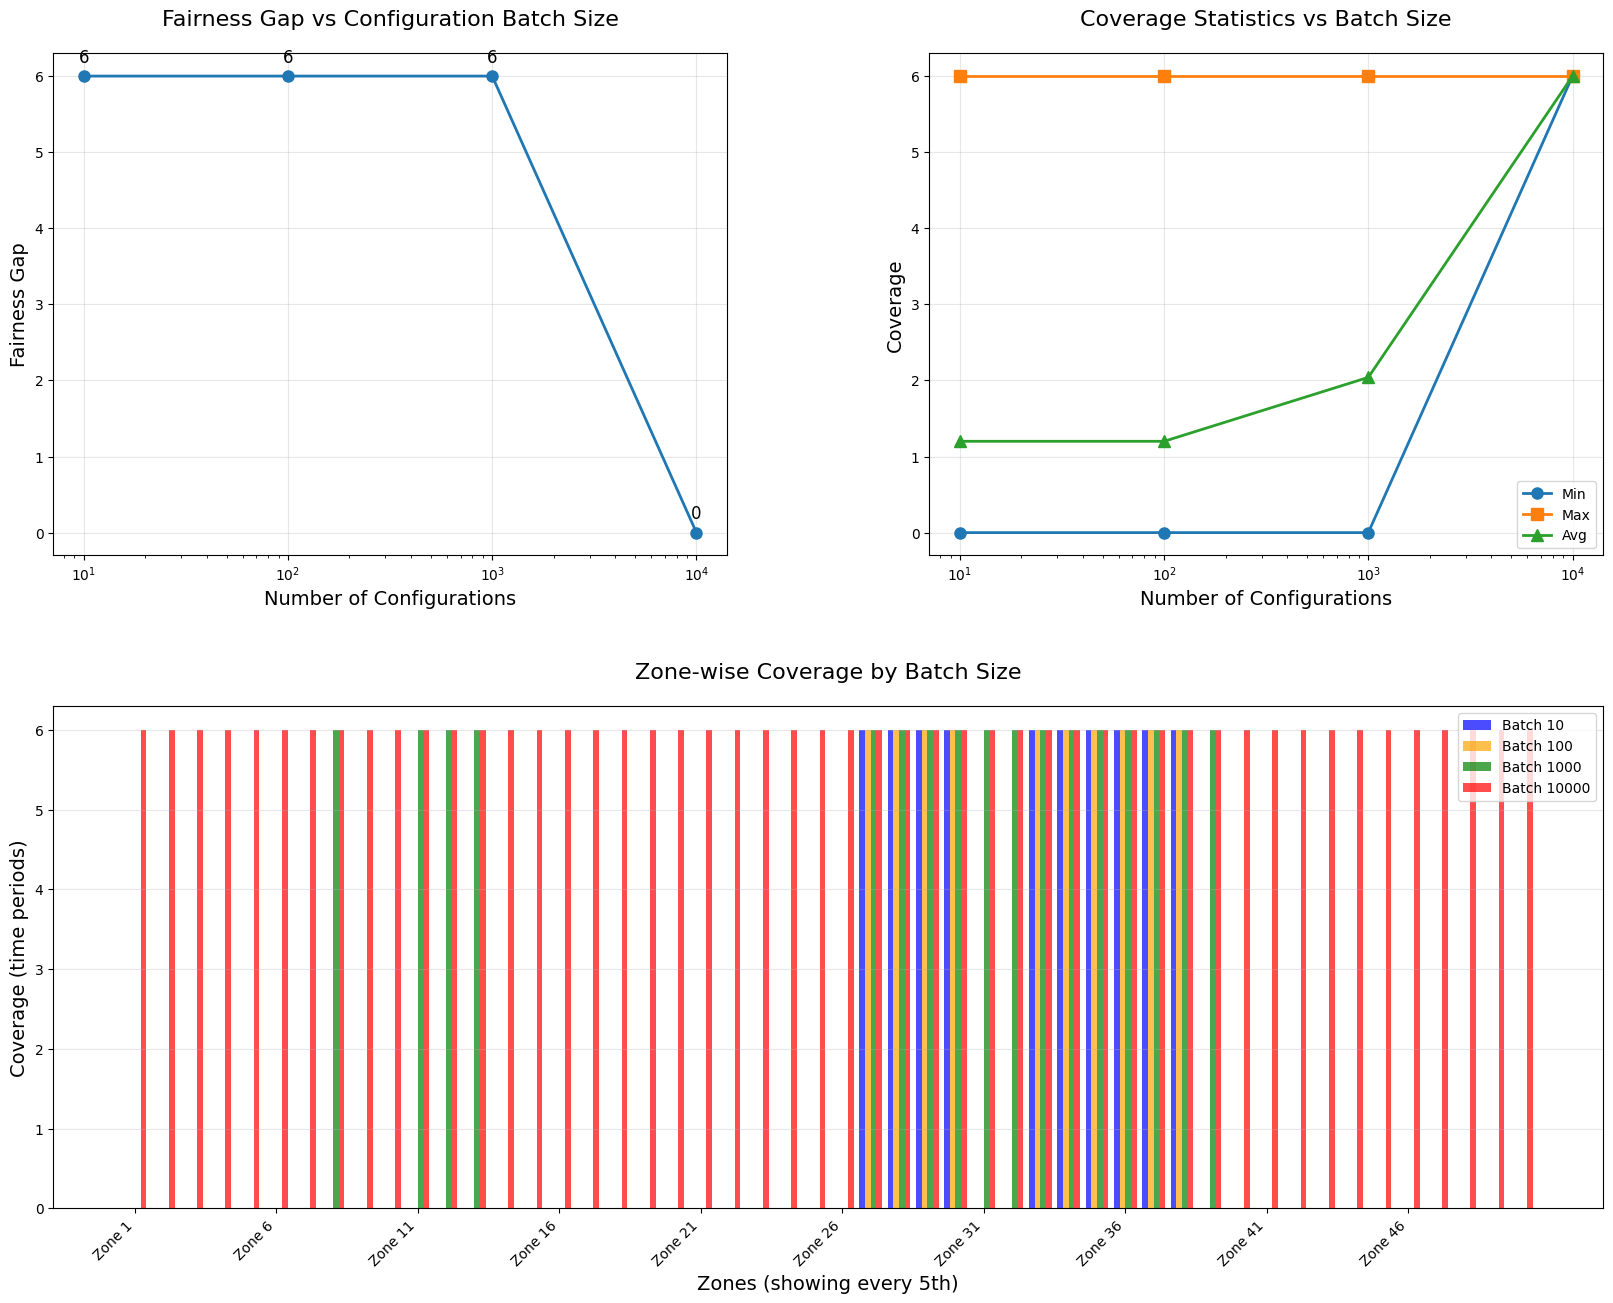

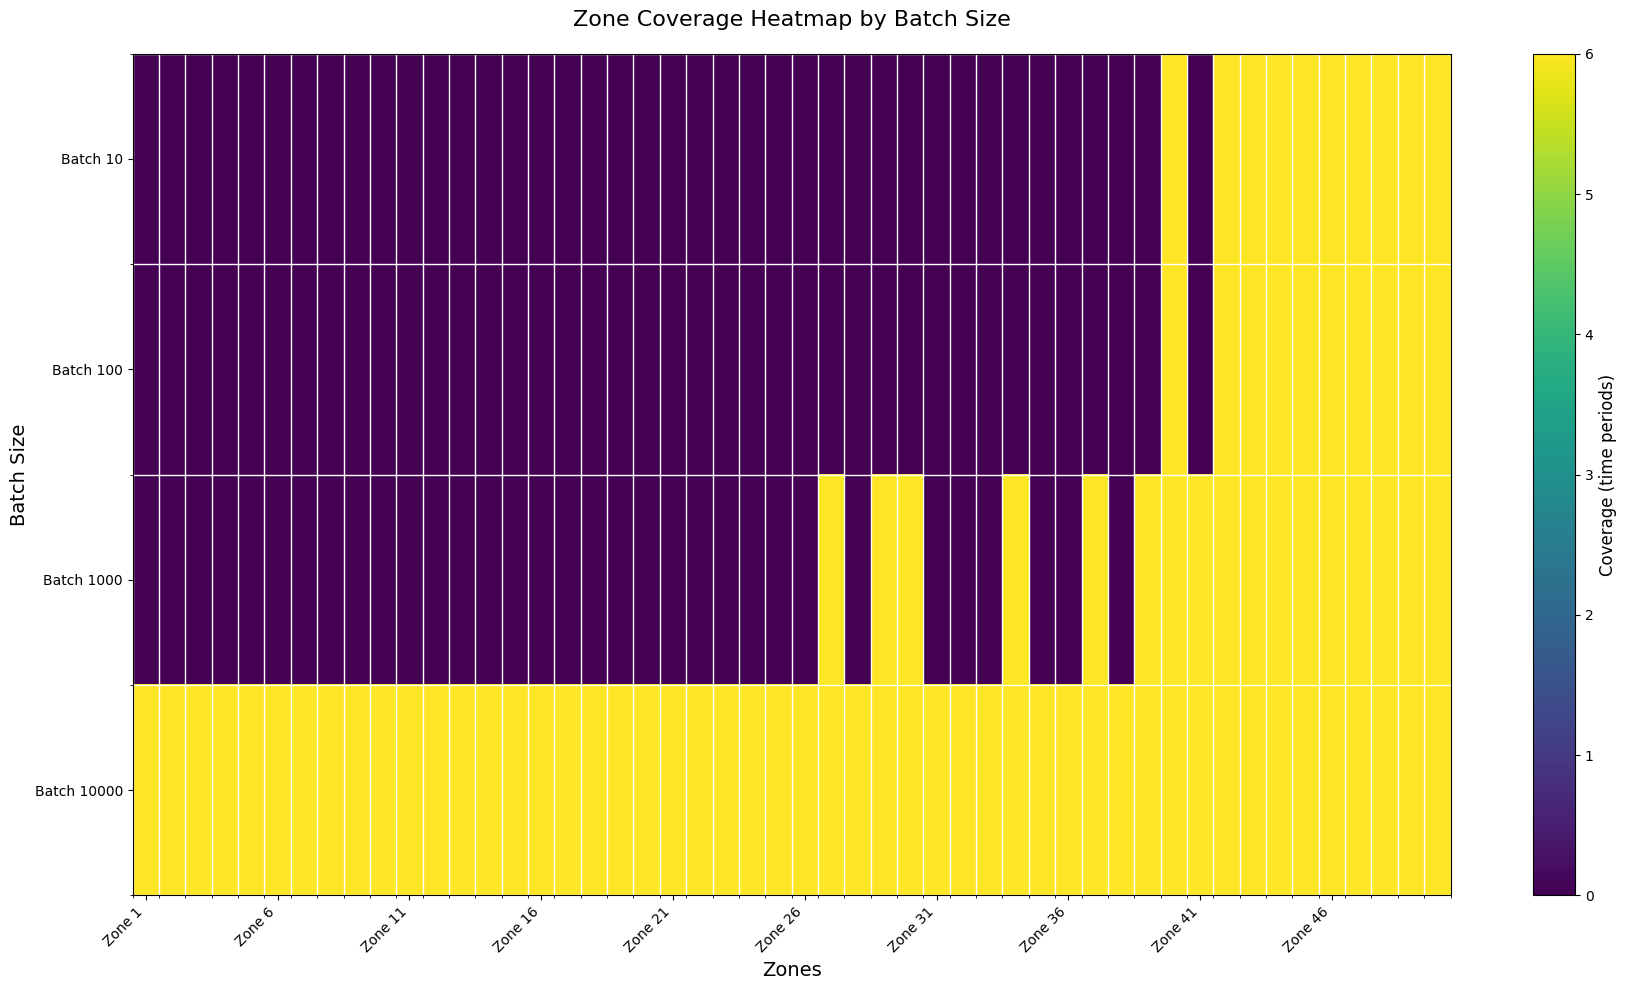

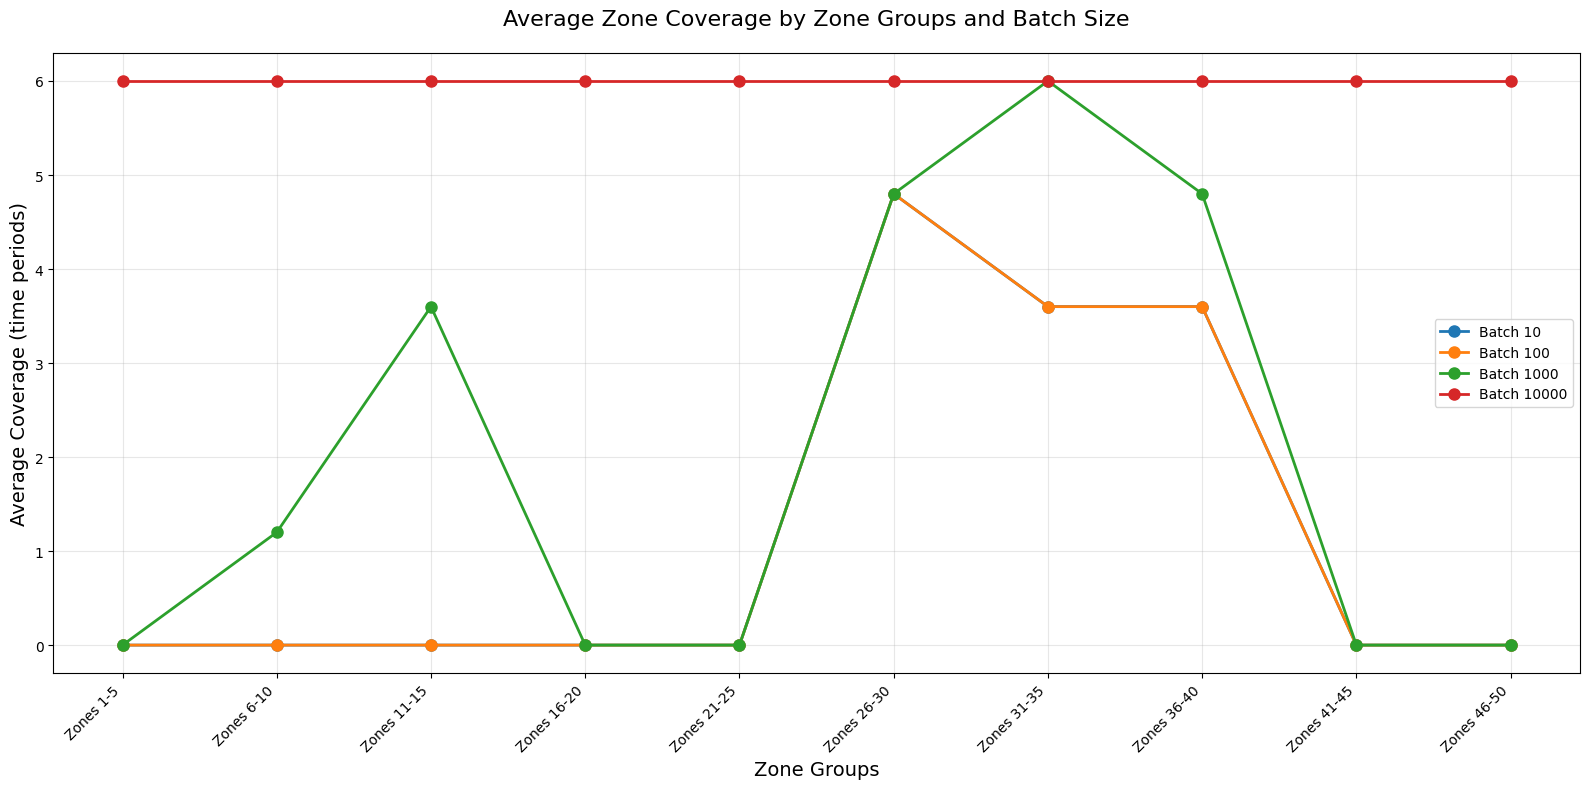

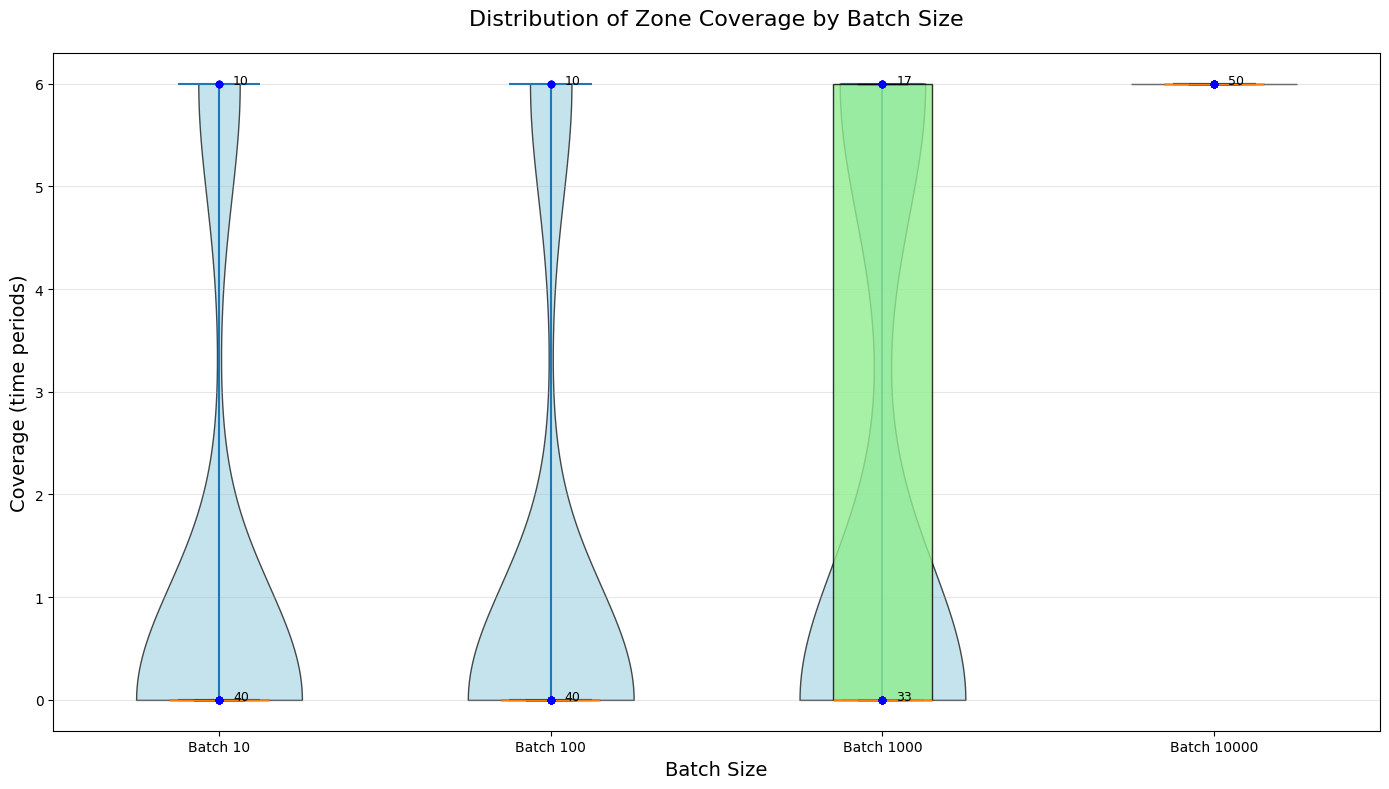

✅ All visualizations completed and saved to the results directory
✅ Results directory: results/Step1A


In [34]:
# Load the saved visualization data
results_dir = "results/Step1A"
with open(os.path.join(results_dir, 'visualization_data.pkl'), 'rb') as f:
    data = pickle.load(f)

# Extract variables
batch_sizes = data['batch_sizes']
results = data['results']
zone_coverage_details = data['zone_coverage_details']
zones = data['zones']
zone_to_num = data['zone_to_num']
num_to_zone = data['num_to_zone']

# Prepare data for plotting
batch_sizes_plot = [r['batch_size'] for r in results]
fairness_gaps = [r['fairness_gap'] for r in results]
min_coverages = [r['min_coverage'] for r in results]
max_coverages = [r['max_coverage'] for r in results]
avg_coverages = [r['avg_coverage'] for r in results]
zone_numbers = list(range(1, len(zones) + 1))

# --- VISUALIZATION: MAIN PLOTS ---
# Create a 2x2 grid for first 3 plots
fig = plt.figure(figsize=(20, 15))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot 1: Fairness gap vs batch size
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(batch_sizes_plot, fairness_gaps, 'o-', linewidth=2, markersize=8)
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Fairness Gap', fontsize=14)
ax1.set_title('Fairness Gap vs Configuration Batch Size', fontsize=16, pad=20)
ax1.grid(True, alpha=0.3)

# Annotate dramatic improvement
for i, (x, y) in enumerate(zip(batch_sizes_plot, fairness_gaps)):
    ax1.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)

# Plot 2: Coverage statistics
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(batch_sizes_plot, min_coverages, 'o-', label='Min', linewidth=2, markersize=8)
ax2.plot(batch_sizes_plot, max_coverages, 's-', label='Max', linewidth=2, markersize=8)
ax2.plot(batch_sizes_plot, avg_coverages, '^-', label='Avg', linewidth=2, markersize=8)
ax2.set_xscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Coverage', fontsize=14)
ax2.set_title('Coverage Statistics vs Batch Size', fontsize=16, pad=20)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Original bar chart
ax3 = fig.add_subplot(gs[1, :])  # Spans both columns of second row
x = np.arange(len(zone_numbers))
width = 0.2

colors = ['blue', 'orange', 'green', 'red']
for idx, (batch_detail, color) in enumerate(zip(zone_coverage_details, colors)):
    coverage_list = []
    for zone_num in zone_numbers:
        zone_coord = num_to_zone[zone_num]
        coverage_list.append(batch_detail['zone_coverage'][str(zone_coord)])
    
    offset = (idx - 1.5) * width
    bars = ax3.bar(x + offset, coverage_list, width, label=f'Batch {batch_detail["batch_size"]}', 
                   alpha=0.7, color=color)

# Only show every 5th label to reduce clutter
xtick_positions = x[::5]
xtick_labels = [f'Zone {n}' for n in zone_numbers[::5]]
ax3.set_xticks(xtick_positions)
ax3.set_xticklabels(xtick_labels, rotation=45, ha='right')
ax3.set_xlabel('Zones (showing every 5th)', fontsize=14)
ax3.set_ylabel('Coverage (time periods)', fontsize=14)
ax3.set_title('Zone-wise Coverage by Batch Size', fontsize=16, pad=20)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'three_plots.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- VISUALIZATION: ALTERNATIVE PLOTS ---

# PLOT OPTION 1: Heatmap
plt.figure(figsize=(18, 10))

# Prepare data for heatmap
heatmap_data = np.zeros((len(batch_sizes), len(zones)))
for b_idx, batch_detail in enumerate(zone_coverage_details):
    for z_idx, zone in enumerate(sorted(zones)):
        heatmap_data[b_idx, z_idx] = batch_detail['zone_coverage'][str(zone)]

# Create heatmap
ax = plt.axes()
im = ax.imshow(heatmap_data, cmap='viridis', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Coverage (time periods)', fontsize=12)

# Configure axes
ax.set_yticks(np.arange(len(batch_sizes)))
ax.set_yticklabels([f'Batch {b}' for b in batch_sizes])

# Only show subset of zone labels to avoid overcrowding
zone_indices = np.arange(0, len(zones), 5)
zone_labels = [f'Zone {zone_to_num[zones[i]]}' for i in zone_indices]
ax.set_xticks(zone_indices)
ax.set_xticklabels(zone_labels, rotation=45, ha='right')

# Add title and axis labels
plt.title('Zone Coverage Heatmap by Batch Size', fontsize=16, pad=20)
plt.xlabel('Zones', fontsize=14)
plt.ylabel('Batch Size', fontsize=14)

# Add grid lines to differentiate cells
ax.set_xticks(np.arange(-.5, len(zones), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(batch_sizes), 1), minor=True)
ax.grid(which='minor', color='w', linestyle='-', linewidth=1)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'zone_coverage_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

# PLOT OPTION 2: Line Plot with Zone Groups
plt.figure(figsize=(16, 8))

# Group zones (e.g., by 5)
group_size = 5
zone_groups = [zones[i:i+group_size] for i in range(0, len(zones), group_size)]

# For each batch size
for b_idx, batch_detail in enumerate(zone_coverage_details):
    batch_size = batch_detail['batch_size']
    
    # Calculate average coverage for each zone group
    group_averages = []
    for group in zone_groups:
        avg_coverage = np.mean([batch_detail['zone_coverage'][str(zone)] for zone in group])
        group_averages.append(avg_coverage)
    
    # Plot line for this batch size
    plt.plot(np.arange(len(zone_groups)), group_averages, 'o-', 
             label=f'Batch {batch_size}', linewidth=2, markersize=8)

# Configure axes
plt.xticks(np.arange(len(zone_groups)), 
           [f'Zones {zone_to_num[group[0]]}-{zone_to_num[group[-1]]}' for group in zone_groups],
           rotation=45, ha='right')
plt.xlabel('Zone Groups', fontsize=14)
plt.ylabel('Average Coverage (time periods)', fontsize=14)
plt.title('Average Zone Coverage by Zone Groups and Batch Size', fontsize=16, pad=20)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'zone_group_coverage.png'), dpi=300, bbox_inches='tight')
plt.show()

# PLOT OPTION 3: Distribution Plot
plt.figure(figsize=(14, 8))

# Prepare data for box plots
data_for_boxplot = []
labels = []

for batch_detail in zone_coverage_details:
    batch_size = batch_detail['batch_size']
    coverage_values = list(batch_detail['zone_coverage'].values())
    data_for_boxplot.append(coverage_values)
    labels.append(f'Batch {batch_size}')

# Create violin plots with embedded box plots
violin_parts = plt.violinplot(data_for_boxplot, showmeans=False, showmedians=True)

# Customize violin plots
for pc in violin_parts['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_edgecolor('black')
    pc.set_alpha(0.7)

# Add box plots inside the violin plots
box_parts = plt.boxplot(data_for_boxplot, positions=np.arange(1, len(data_for_boxplot) + 1), 
                        widths=0.3, patch_artist=True, showfliers=False)

# Customize box plots
for box in box_parts['boxes']:
    box.set(facecolor='lightgreen', alpha=0.8)

# Add individual data points
for i, dataset in enumerate(data_for_boxplot):
    plt.scatter(np.repeat(i+1, len(dataset)), dataset, alpha=0.5, 
                color='blue', s=20, zorder=10)

# Configure axes
plt.xticks(np.arange(1, len(labels) + 1), labels)
plt.xlabel('Batch Size', fontsize=14)
plt.ylabel('Coverage (time periods)', fontsize=14)
plt.title('Distribution of Zone Coverage by Batch Size', fontsize=16, pad=20)
plt.grid(axis='y', alpha=0.3)

# Add coverage counts as annotations
for i, dataset in enumerate(data_for_boxplot):
    # Count occurrences of each value
    unique_vals, counts = np.unique(dataset, return_counts=True)
    
    # Sort by value
    sort_idx = np.argsort(unique_vals)
    unique_vals = unique_vals[sort_idx]
    counts = counts[sort_idx]
    
    # Add count annotations
    for val, count in zip(unique_vals, counts):
        plt.annotate(f'{count}', 
                    (i+1, val), 
                    xytext=(10, 0), 
                    textcoords='offset points',
                    fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'zone_coverage_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ All visualizations completed and saved to the results directory")
print(f"✅ Results directory: {results_dir}")

# STEP 2 >>> Run experiments on the entire set of configurations - Compare the computation times and analyze the differences 

#### Master Problem ILP construction (Configuration-based / full comparison)

### STEP 2 - Part 1 >>> Setup and Optimization

In [35]:
# --- SETTINGS ---
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Create the results directory
results_dir = "results/Step2"
os.makedirs(results_dir, exist_ok=True)

# Define parameter variations for comprehensive analysis
T_VALUES = [3, 6, 9]  # Different time periods
BATCH_SIZES = [100, 1000, 10000, 100000, 1000000]  # Different batch sizes
MAX_CONFIGS = {  # Maximum available configs for each T
    3: 1296,
    6: 10295472,
    9: 78639000
}

# --- LOAD GRAPH ---
with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# Store comprehensive results
all_results = []

# Main analysis loop
for T in T_VALUES:
    print(f"\n{'='*80}")
    print(f"ANALYZING WITH T = {T} TIME PERIODS")
    print(f"{'='*80}")
    
    # Generate configurations for this T value
    # Note: In practice, you'd generate configurations for different T values
    # For this example, we'll use the existing configurations
    
    for batch_size in BATCH_SIZES:
        # Skip if batch size exceeds available configurations
        if batch_size > MAX_CONFIGS.get(T, batch_size):
            print(f"⚠️ Skipping batch size {batch_size} for T={T} (exceeds available configurations)")
            continue
            
        print(f"\nTesting T={T}, Batch Size={batch_size}")
        print(f"{'-'*50}")
        
        try:
            # Timing experiment
            start_time = time.time()
            
            # Reload environment using the same params approach as Step 1
            env = gp.Env(params=params)  # Using params from Step 1
            model = gp.Model(env=env)
            
            # --- LOAD CONFIGURATIONS ---
            df = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv")).head(batch_size)
            configurations = []
            for _, row in df.iterrows():
                config = []
                for i in range(len(base_coords)):
                    config.append(int(row[f"base{i}_ambulances"]))
                configurations.append(tuple(config))
            
            # --- BUILD COVERAGE MATRIX ---
            build_start = time.time()
            b = {}
            for c_idx, config in enumerate(configurations):
                for base_idx, num_ambulances in enumerate(config):
                    if num_ambulances > 0:
                        base_zone = base_coords[base_idx]
                        coverage = {base_zone} | adjacency.get(base_zone, set())
                        for t in range(T):
                            for z in coverage:
                                b[(z, t, c_idx)] = 1
            build_time = time.time() - build_start
            
            # --- MODEL VARIABLES ---
            λ = model.addVars(len(configurations), vtype=GRB.BINARY, name="lambda")
            y = model.addVars(zones, vtype=GRB.INTEGER, name="y")
            z = model.addVar(vtype=GRB.INTEGER, name="z")
            
            # --- CONSTRAINTS ---
            model_build_start = time.time()
            model.addConstr(gp.quicksum(λ[c] for c in range(len(configurations))) == 1, "select_one_config")
            
            for i in zones:
                model.addConstr(
                    y[i] == gp.quicksum(b.get((i, t, c), 0) * λ[c] for c in range(len(configurations)) for t in range(T)),
                    f"coverage_{i}"
                )
            
            for i in zones:
                for j in zones:
                    model.addConstr(z >= y[i] - y[j], f"fair_{i}_{j}")
            
            model.setObjective(z, GRB.MINIMIZE)
            model_build_time = time.time() - model_build_start
            
            # --- SOLVE ---
            solve_start = time.time()
            model.optimize()
            solve_time = time.time() - solve_start
            
            total_time = time.time() - start_time
            
            # --- COLLECT RESULTS ---
            selected_idx = [c for c in range(len(configurations)) if λ[c].X > 0.5][0]
            selected_config = configurations[selected_idx]
            
            # Collect statistics
            coverage_values = [int(y[i].X) for i in zones]
            fairness_gap = int(z.X)
            
            # Store results
            result = {
                'T': T,
                'batch_size': batch_size,
                'fairness_gap': fairness_gap,
                'min_coverage': min(coverage_values),
                'max_coverage': max(coverage_values),
                'avg_coverage': np.mean(coverage_values),
                'coverage_std': np.std(coverage_values),
                'num_variables': model.numVars,
                'num_constraints': model.numConstrs,
                'total_time': total_time,
                'build_time': build_time,
                'model_build_time': model_build_time,
                'solve_time': solve_time
            }
            all_results.append(result)
            
            print(f"✅ Success: Fairness gap = {fairness_gap}, Total time = {total_time:.2f}s")
            
            # Clean up
            model.dispose()
            env.dispose()
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            continue

# Convert results to DataFrame and save
df_results = pd.DataFrame(all_results)
df_results.to_csv(os.path.join(results_dir, 'comprehensive_results.csv'), index=False)
print(f"\n✅ Saved comprehensive results to '{results_dir}/comprehensive_results.csv'")

# Save data for visualization
visualization_data = {
    'T_VALUES': T_VALUES,
    'BATCH_SIZES': BATCH_SIZES,
    'results': all_results
}

with open(os.path.join(results_dir, 'visualization_data.pkl'), 'wb') as f:
    pickle.dump(visualization_data, f)
print(f"✅ Saved visualization data to '{results_dir}/visualization_data.pkl'")

# --- DETAILED ANALYSIS REPORT ---
print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS REPORT")
print("="*80)

# Summary statistics by T value
print("\nSUMMARY BY T VALUE:")
print("-"*50)
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        print(f"\nT = {T}:")
        print(f"  Configurations tested: {len(T_data)}")
        print(f"  Best fairness gap: {T_data['fairness_gap'].min()}")
        print(f"  Average computation time: {T_data['total_time'].mean():.2f}s")
        print(f"  Max model size: {T_data['num_variables'].max():,} variables")

# Scaling analysis
print("\nSCALING ANALYSIS:")
print("-"*50)
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T].sort_values('batch_size')
    if len(T_data) > 1:
        batch_ratio = T_data['batch_size'].iloc[-1] / T_data['batch_size'].iloc[0]
        time_ratio = T_data['total_time'].iloc[-1] / T_data['total_time'].iloc[0]
        print(f"T = {T}:")
        print(f"  Batch size ratio: {batch_ratio:.1f}x")
        print(f"  Time ratio: {time_ratio:.1f}x")
        print(f"  Efficiency factor: {time_ratio/batch_ratio:.3f}")

# Optimal configurations found
print("\nOPTIMAL CONFIGURATIONS:")
print("-"*50)
for T in T_VALUES:
    best = df_results[df_results['T'] == T].nsmallest(1, 'fairness_gap')
    if len(best) > 0:
        print(f"T = {T}:")
        print(f"  Batch size: {best['batch_size'].iloc[0]:,}")
        print(f"  Fairness gap: {best['fairness_gap'].iloc[0]}")
        print(f"  Computation time: {best['total_time'].iloc[0]:.2f}s")

Number of zones: 50
Number of bases: 5

ANALYZING WITH T = 3 TIME PERIODS

Testing T=3, Batch Size=100
--------------------------------------------------
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2659300
Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.4.0 24E263)

CPU model: Apple M4 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Academic license 2659300 - for non-commercial use only - registered to ab___@cornell.edu
Optimize a model with 2551 rows, 151 columns and 10375 nonzeros
Model fingerprint: 0xd3707c83
Variable types: 0 continuous, 151 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 2551 rows and 151 columns
Presolve time: 0.00s
Presolve: All 

### STEP 2 - Part 2: Visualization and Analysis

/var/folders/_2/nvq16qmj48g5ggtmz5d52m000000gn/T/ipykernel_85807/167396433.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


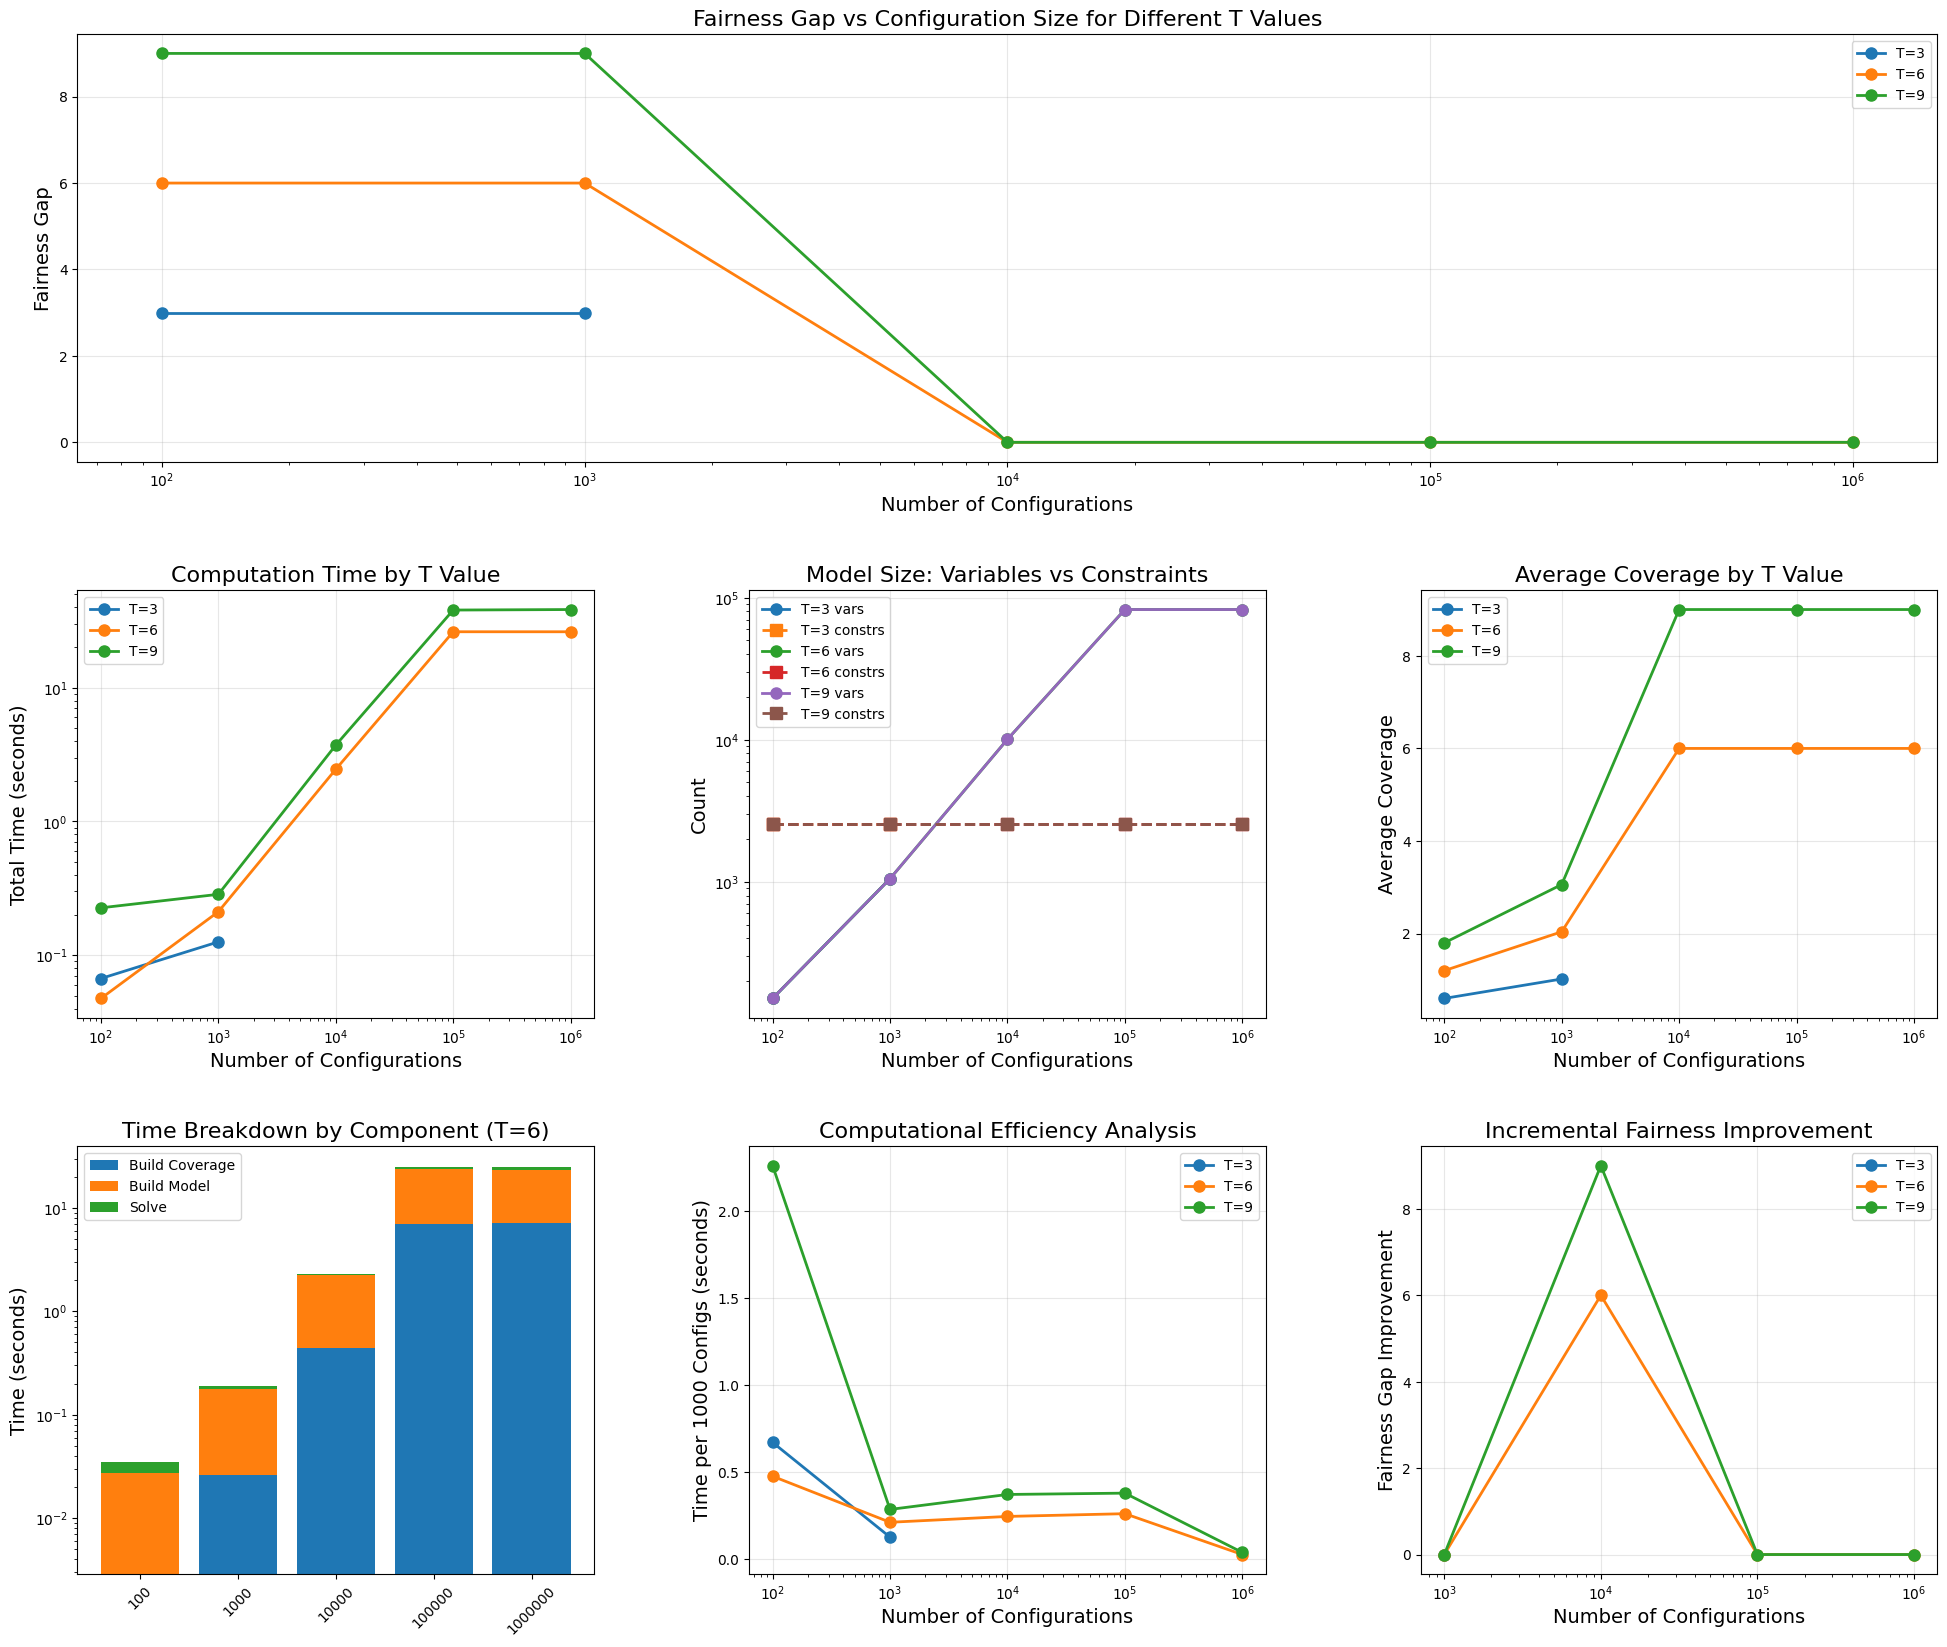

✅ Saved efficiency summary to 'results/Step2/efficiency_summary.csv'


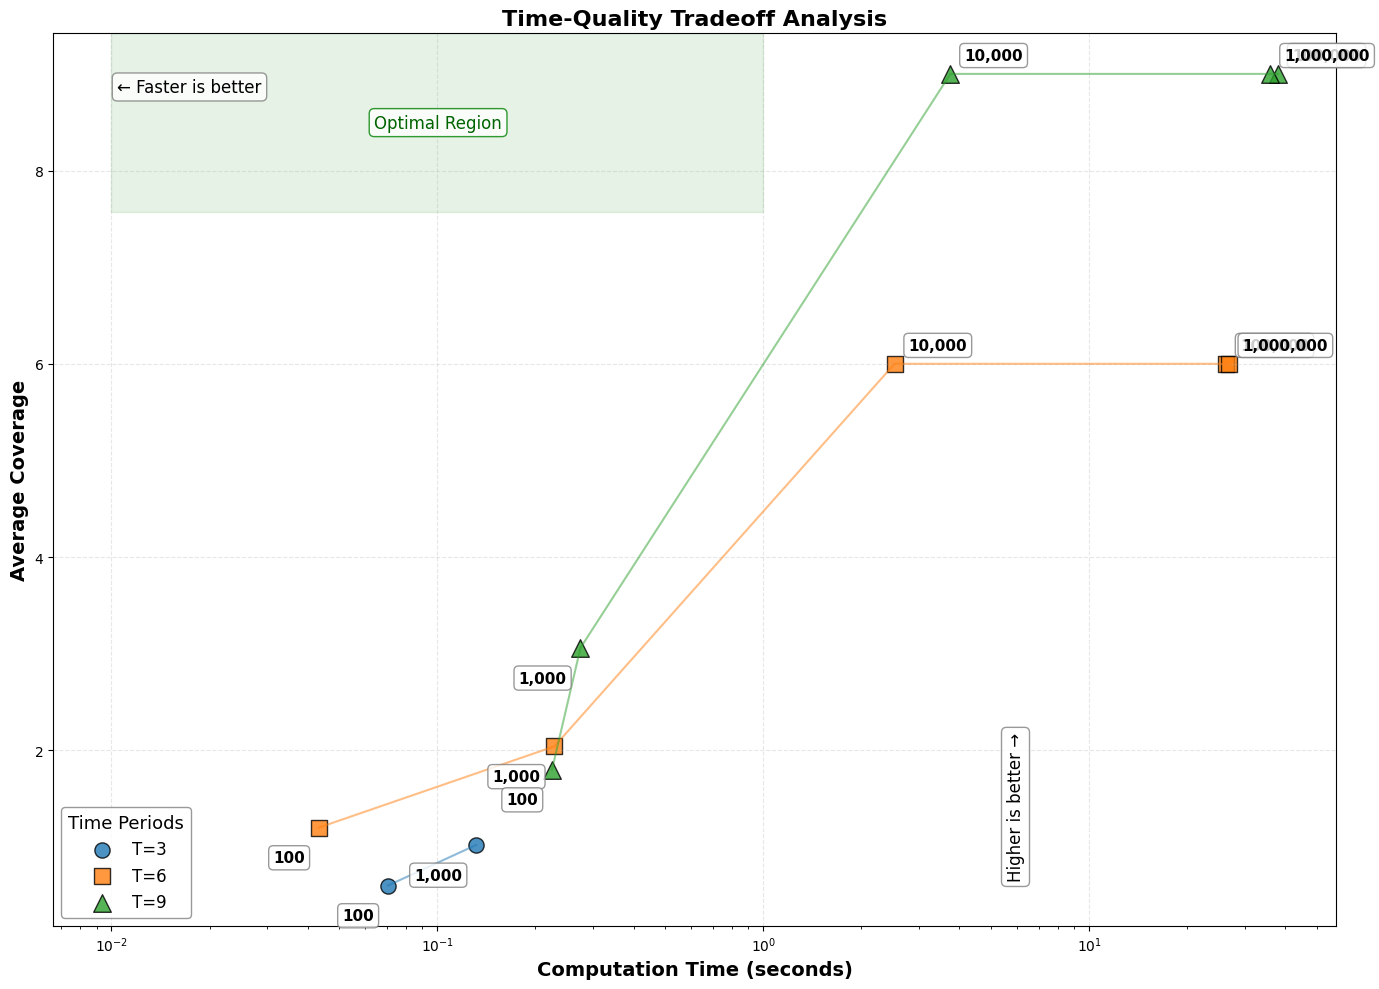

✅ Saved summary table to 'results/Step2/summary_table.csv'

--- Visualization and analysis completed ---


/var/folders/_2/nvq16qmj48g5ggtmz5d52m000000gn/T/ipykernel_85807/167396433.py:225: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_table = pd.concat([summary_table, pd.DataFrame({


In [42]:
# Load data from Part 1
results_dir = "results/Step2"
with open(os.path.join(results_dir, 'visualization_data.pkl'), 'rb') as f:
    data = pickle.load(f)

# Extract variables
T_VALUES = data['T_VALUES']
BATCH_SIZES = data['BATCH_SIZES']
all_results = data['results']

# Convert results to DataFrame
df_results = pd.DataFrame(all_results)

# --- COMPREHENSIVE VISUALIZATION ---
# Create visualization grid
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Fairness Gap by T and Batch Size
ax1 = fig.add_subplot(gs[0, :])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax1.plot(T_data['batch_size'], T_data['fairness_gap'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax1.set_xscale('log')
ax1.set_xlabel('Number of Configurations', fontsize=14)
ax1.set_ylabel('Fairness Gap', fontsize=14)
ax1.set_title('Fairness Gap vs Configuration Size for Different T Values', fontsize=16)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Computation Time Comparison
ax2 = fig.add_subplot(gs[1, 0])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax2.plot(T_data['batch_size'], T_data['total_time'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Configurations', fontsize=14)
ax2.set_ylabel('Total Time (seconds)', fontsize=14)
ax2.set_title('Computation Time by T Value', fontsize=16)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Model Size (Variables and Constraints)
ax3 = fig.add_subplot(gs[1, 1])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax3.plot(T_data['batch_size'], T_data['num_variables'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T} vars')
        ax3.plot(T_data['batch_size'], T_data['num_constraints'], 's--', 
                linewidth=2, markersize=8, label=f'T={T} constrs')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlabel('Number of Configurations', fontsize=14)
ax3.set_ylabel('Count', fontsize=14)
ax3.set_title('Model Size: Variables vs Constraints', fontsize=16)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Coverage Quality Metrics
ax4 = fig.add_subplot(gs[1, 2])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        ax4.plot(T_data['batch_size'], T_data['avg_coverage'], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax4.set_xscale('log')
ax4.set_xlabel('Number of Configurations', fontsize=14)
ax4.set_ylabel('Average Coverage', fontsize=14)
ax4.set_title('Average Coverage by T Value', fontsize=16)
ax4.legend()
ax4.grid(True, alpha=0.3)

# Plot 5: Time Breakdown
ax5 = fig.add_subplot(gs[2, 0])
times_data = df_results[df_results['T'] == 6]  # Example with T=6
if len(times_data) > 0:
    bottom = np.zeros(len(times_data))
    for component, label in [('build_time', 'Build Coverage'),
                            ('model_build_time', 'Build Model'),
                            ('solve_time', 'Solve')]:
        ax5.bar(range(len(times_data)), times_data[component], 
                bottom=bottom, label=label)
        bottom += times_data[component]
    ax5.set_xticks(range(len(times_data)))
    ax5.set_xticklabels(times_data['batch_size'], rotation=45)
    ax5.set_ylabel('Time (seconds)', fontsize=14)
    ax5.set_title(f'Time Breakdown by Component (T=6)', fontsize=16)
    ax5.legend()
    ax5.set_yscale('log')

# Plot 6: Efficiency Analysis (Time per 1000 configurations)
ax6 = fig.add_subplot(gs[2, 1])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T]
    if len(T_data) > 0:
        efficiency = T_data['total_time'] / (T_data['batch_size'] / 1000)
        ax6.plot(T_data['batch_size'], efficiency, 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax6.set_xscale('log')
ax6.set_xlabel('Number of Configurations', fontsize=14)
ax6.set_ylabel('Time per 1000 Configs (seconds)', fontsize=14)
ax6.set_title('Computational Efficiency Analysis', fontsize=16)
ax6.legend()
ax6.grid(True, alpha=0.3)

# Plot 7: Fairness Improvement Rate
ax7 = fig.add_subplot(gs[2, 2])
for T in T_VALUES:
    T_data = df_results[df_results['T'] == T].sort_values('batch_size')
    if len(T_data) > 1:
        improvement = T_data['fairness_gap'].diff().abs()
        ax7.plot(T_data['batch_size'].iloc[1:], improvement.iloc[1:], 'o-', 
                linewidth=2, markersize=8, label=f'T={T}')
ax7.set_xscale('log')
ax7.set_xlabel('Number of Configurations', fontsize=14)
ax7.set_ylabel('Fairness Gap Improvement', fontsize=14)
ax7.set_title('Incremental Fairness Improvement', fontsize=16)
ax7.legend()
ax7.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'comprehensive_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create efficiency summary
efficiency_summary = []
for T in T_VALUES:
    for batch_size in BATCH_SIZES:
        data = df_results[(df_results['T'] == T) & (df_results['batch_size'] == batch_size)]
        if len(data) > 0:
            efficiency_summary.append({
                'T': T,
                'batch_size': batch_size,
                'fairness_gap': data['fairness_gap'].iloc[0],
                'time_per_1000_configs': data['total_time'].iloc[0] / (batch_size / 1000)
            })

efficiency_df = pd.DataFrame(efficiency_summary)
if len(efficiency_df) > 0:
    efficiency_df.to_csv(os.path.join(results_dir, 'efficiency_summary.csv'), index=False)
    print(f"✅ Saved efficiency summary to '{results_dir}/efficiency_summary.csv'")

# Plot 9: Improved Time vs Coverage Quality
plt.figure(figsize=(14, 10))

# Use different marker styles and sizes for better visibility
markers = ['o', 's', '^']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # More distinct colors
sizes = [120, 140, 160]

for i, T in enumerate(T_VALUES):
    T_data = df_results[df_results['T'] == T].copy()
    if len(T_data) > 0:
        # Create jitter for better visibility
        jitter = np.random.normal(0, 0.05, len(T_data))
        T_data['time_jittered'] = T_data['total_time'] * (1 + jitter)
        
        # Plot with more distinct markers
        plt.scatter(T_data['time_jittered'], T_data['avg_coverage'], 
                  s=sizes[i], alpha=0.8, label=f'T={T}',
                  marker=markers[i], edgecolors='black', linewidths=1)
        
        # Draw connecting lines
        plt.plot(T_data['time_jittered'], T_data['avg_coverage'], '-', 
                color=colors[i], alpha=0.5, linewidth=1.5)
        
        # Annotate points with batch size
        for _, row in T_data.iterrows():
            # Position text strategically based on batch size
            if row['batch_size'] <= 1000:
                xytext = (-10, -25)  # Below
                ha = 'right'
            else:
                xytext = (10, 10)  # Above right
                ha = 'left'
                
            plt.annotate(f"{int(row['batch_size']):,}", 
                       (row['time_jittered'], row['avg_coverage']),
                       xytext=xytext, textcoords='offset points',
                       fontsize=11, fontweight='bold', ha=ha,
                       bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Improve axes and grid
plt.xscale('log')
plt.xlabel('Computation Time (seconds)', fontsize=14, fontweight='bold')
plt.ylabel('Average Coverage', fontsize=14, fontweight='bold')
plt.title('Time-Quality Tradeoff Analysis', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')

# Add a more detailed legend
legend = plt.legend(title="Time Periods", fontsize=12, title_fontsize=13, 
           frameon=True, facecolor='white', edgecolor='gray')

# Add explanatory annotation
plt.annotate("Higher is better →", xy=(0.75, 0.05), xycoords='axes fraction', 
             fontsize=12, ha='center', va='bottom', rotation=90, 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
plt.annotate("← Faster is better", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, ha='left', va='top',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Show "optimal region" - high coverage, low time
plt.axvspan(0.01, 1, ymin=0.8, ymax=1, alpha=0.1, color='green', zorder=1)
plt.annotate("Optimal Region", xy=(0.3, 0.9), xycoords='axes fraction', 
             fontsize=12, ha='center', va='center', color='darkgreen',
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="green", alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'improved_time_quality_tradeoff.png'), dpi=300, bbox_inches='tight')
plt.show()

# Create summary table for report
summary_table = pd.DataFrame(columns=['T', 'Best Batch Size', 'Best Fairness Gap', 
                                     'Avg Coverage', 'Computation Time (s)'])

for T in T_VALUES:
    best_row = df_results[df_results['T'] == T].nsmallest(1, 'fairness_gap')
    if len(best_row) > 0:
        summary_table = pd.concat([summary_table, pd.DataFrame({
            'T': [T],
            'Best Batch Size': [int(best_row['batch_size'].iloc[0])],
            'Best Fairness Gap': [best_row['fairness_gap'].iloc[0]],
            'Avg Coverage': [best_row['avg_coverage'].iloc[0]],
            'Computation Time (s)': [best_row['total_time'].iloc[0]]
        })])

summary_table.to_csv(os.path.join(results_dir, 'summary_table.csv'), index=False)
print(f"✅ Saved summary table to '{results_dir}/summary_table.csv'")
print("\n--- Visualization and analysis completed ---")

# STEP 3 >>> Implement binarization - Define a reasonable upper bound (T+1) for how many times a configuration can occur (like 3, 5, 10, etc.), implement the unary expansion technique you described, and compare this formulation with the original model in terms of: 
#### Number of variables, Solution quality, Computation time


#### For Binarization

	•	The key insight in your binarization technique is transforming integer variables Q (representing how many times a configuration occurs) into binary variables using:
	•	Q = 0×Z₀ + 1×Z₁ + 2×Z₂ + ... + T×Zₜ
	•	With the constraint: Z₀ + Z₁ + Z₂ + ... + Zₜ = 1 (exactly one binary variable is selected)

In [43]:
# Configuration-Based Unary Binarization (Step 3) with Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import os
import pickle
import time

# --- PARAMETERS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
FILENAME = "50-3004-6-7-35"
CONFIG_DIR = f"./configurations/50/{FILENAME}_allocations"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Create results directory
results_dir = "results/Step3"
os.makedirs(results_dir, exist_ok=True)

# Define reasonable upper bound for configuration frequency
MAX_CONFIG_FREQUENCY = 5  # A configuration can occur 0-5 times

# Set up license parameters (same as in Step 2)
params = {
    'WLSAccessID': '',  # Leave blank as it appears to work without explicit values
    'WLSSecret': '',    # Leave blank as it appears to work without explicit values
    'LicenseID': '2659300'  # The academic license ID from Step 1 output
}

# --- LOAD GRAPH ---
env = gp.Env(params=params)
model_original = gp.Model(env=env)
model_binarized = gp.Model(env=env)

with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)
adjacency = {node: set(G.neighbors(node)) for node in G.nodes}
zones = list(G.nodes)

# --- LOAD BASE COORDINATES ---
with open(os.path.join(DATA_DIR, f"{FILENAME}.bases"), "r") as f:
    base_coords = [eval(line.strip()) for line in f if line.strip()]

print(f"Number of zones: {len(zones)}")
print(f"Number of bases: {len(base_coords)}")

# --- LOAD CONFIGURATIONS ---
NUM_CONFIGS = 1000  # Test with reasonable number
df = pd.read_csv(os.path.join(CONFIG_DIR, "configurations.csv")).head(NUM_CONFIGS)
configurations = []
for _, row in df.iterrows():
    config = []
    for i in range(len(base_coords)):
        config.append(int(row[f"base{i}_ambulances"]))
    configurations.append(tuple(config))

print(f"Loaded {len(configurations)} configurations")
print(f"First 3 configurations: {configurations[:3]}")

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
b = {}
for c_idx, config in enumerate(configurations):
    for base_idx, num_ambulances in enumerate(config):
        if num_ambulances > 0:
            base_zone = base_coords[base_idx]
            coverage = {base_zone} | adjacency.get(base_zone, set())
            for t in range(T):
                for z in coverage:
                    b[(z, t, c_idx)] = 1

# --- ORIGINAL MODEL ---
# Variables
λ_original = model_original.addVars(NUM_CONFIGS, vtype=GRB.BINARY, name="lambda_original")
y_original = model_original.addVars(zones, vtype=GRB.INTEGER, name="y_original")  
z_original = model_original.addVar(vtype=GRB.INTEGER, name="z_original")

# Constraints
model_original.addConstr(gp.quicksum(λ_original[c] for c in range(NUM_CONFIGS)) == 1, "select_one_config_original")

for i in zones:
    model_original.addConstr(
        y_original[i] == gp.quicksum(b.get((i, t, c), 0) * λ_original[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_original_{i}"
    )

for i in zones:
    for j in zones:
        model_original.addConstr(z_original >= y_original[i] - y_original[j], f"fair_original_{i}_{j}")

model_original.setObjective(z_original, GRB.MINIMIZE)

# --- BINARIZED MODEL (Unary Expansion) ---
# Variables
# Z[c, k]: binary variable indicating if configuration c occurs k times
Z = {}
for c in range(NUM_CONFIGS):
    for k in range(MAX_CONFIG_FREQUENCY + 1):
        Z[c, k] = model_binarized.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")

# q[c]: integer variable representing how many times configuration c occurs
q = model_binarized.addVars(NUM_CONFIGS, vtype=GRB.INTEGER, name="q")

y_binarized = model_binarized.addVars(zones, vtype=GRB.INTEGER, name="y_binarized")
z_binarized = model_binarized.addVar(vtype=GRB.INTEGER, name="z_binarized")

# Constraints
# One-hot constraint: Each configuration occurs exactly once with some frequency
for c in range(NUM_CONFIGS):
    model_binarized.addConstr(
        gp.quicksum(Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
        f"one_hot_{c}"
    )

# Link q to Z: q[c] = sum(k * Z[c,k])
for c in range(NUM_CONFIGS):
    model_binarized.addConstr(
        q[c] == gp.quicksum(k * Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)),
        f"link_q_{c}"
    )

# Total ambulance count constraint
model_binarized.addConstr(
    gp.quicksum(q[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES,
    "ambulance_count_binarized"
)

# Coverage constraints
for i in zones:
    model_binarized.addConstr(
        y_binarized[i] == gp.quicksum(b.get((i, t, c), 0) * q[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_binarized_{i}"
    )

# Fairness constraints
for i in zones:
    for j in zones:
        model_binarized.addConstr(z_binarized >= y_binarized[i] - y_binarized[j], f"fair_binarized_{i}_{j}")

model_binarized.setObjective(z_binarized, GRB.MINIMIZE)

# --- SOLVE BOTH MODELS AND COMPARE ---
print("\nSolving original model...")
start_original = time.time()
model_original.optimize()
time_original = time.time() - start_original

print("\nSolving binarized model...")
start_binarized = time.time()
model_binarized.optimize()
time_binarized = time.time() - start_binarized

# --- RESULTS COMPARISON ---
print("\n=== COMPARISON RESULTS ===")
print(f"{'Metric':<25} | {'Original Model':<15} | {'Binarized Model':<15}")
print("-" * 60)
print(f"{'Number of Variables':<25} | {model_original.numVars:<15} | {model_binarized.numVars:<15}")
print(f"{'Number of Constraints':<25} | {model_original.numConstrs:<15} | {model_binarized.numConstrs:<15}")
print(f"{'Objective Value':<25} | {model_original.objVal:<15.2f} | {model_binarized.objVal:<15.2f}")
print(f"{'Solve Time (seconds)':<25} | {time_original:<15.2f} | {time_binarized:<15.2f}")

print("\n=== SELECTED CONFIGURATION FREQUENCIES ===")
print("Original Model (binary selection):")
selected_original = [(c, λ_original[c].X) for c in range(NUM_CONFIGS) if λ_original[c].X > 0.5]
print(f"Number of selected configs: {len(selected_original)}")

print("\nBinarized Model (unary expansion):")
selected_binarized = [(c, int(q[c].X)) for c in range(NUM_CONFIGS) if q[c].X > 0.5]
print(f"Number of configurations with frequency > 0: {len(selected_binarized)}")
for c, freq in selected_binarized:
    print(f"  Config {c}: {freq} times")

# --- SCALING ANALYSIS ---
# Test with different config sizes and MAX_CONFIG_FREQUENCY values
scaling_results = []
config_sizes = [100, 500, 1000]  # Adjusted for reasonable runtime
frequency_bounds = [3, 5, 7]

for size in config_sizes:
    for freq_bound in frequency_bounds:
        print(f"\nTesting with {size} configurations and max frequency {freq_bound}")
        # Reset models
        model_orig_scale = gp.Model(env=env)
        model_bin_scale = gp.Model(env=env)
        
        # Use subset of configs
        configs_subset = configurations[:size]
        
        # Build coverage matrix
        b_subset = {}
        for c_idx, config in enumerate(configs_subset):
            for base_idx, num_ambulances in enumerate(config):
                if num_ambulances > 0:
                    base_zone = base_coords[base_idx]
                    coverage = {base_zone} | adjacency.get(base_zone, set())
                    for t in range(T):
                        for z in coverage:
                            b_subset[(z, t, c_idx)] = 1
        
        # Original model
        λ_scale = model_orig_scale.addVars(size, vtype=GRB.BINARY, name="lambda")
        y_scale = model_orig_scale.addVars(zones, vtype=GRB.INTEGER, name="y")
        z_scale = model_orig_scale.addVar(vtype=GRB.INTEGER, name="z")
        
        model_orig_scale.addConstr(gp.quicksum(λ_scale[c] for c in range(size)) == 1)
        
        for i in zones:
            model_orig_scale.addConstr(
                y_scale[i] == gp.quicksum(b_subset.get((i, t, c), 0) * λ_scale[c] for c in range(size) for t in range(T))
            )
        
        for i in zones:
            for j in zones:
                model_orig_scale.addConstr(z_scale >= y_scale[i] - y_scale[j])
        
        model_orig_scale.setObjective(z_scale, GRB.MINIMIZE)
        
        # Binarized model
        Z_scale = {}
        for c in range(size):
            for k in range(freq_bound + 1):
                Z_scale[c, k] = model_bin_scale.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")
        
        q_scale = model_bin_scale.addVars(size, vtype=GRB.INTEGER, name="q")
        y_scale_bin = model_bin_scale.addVars(zones, vtype=GRB.INTEGER, name="y")
        z_scale_bin = model_bin_scale.addVar(vtype=GRB.INTEGER, name="z")
        
        for c in range(size):
            model_bin_scale.addConstr(gp.quicksum(Z_scale[c, k] for k in range(freq_bound + 1)) == 1)
            model_bin_scale.addConstr(q_scale[c] == gp.quicksum(k * Z_scale[c, k] for k in range(freq_bound + 1)))
        
        model_bin_scale.addConstr(gp.quicksum(q_scale[c] for c in range(size)) == NUM_AMBULANCES)
        
        for i in zones:
            model_bin_scale.addConstr(
                y_scale_bin[i] == gp.quicksum(b_subset.get((i, t, c), 0) * q_scale[c] for c in range(size) for t in range(T))
            )
        
        for i in zones:
            for j in zones:
                model_bin_scale.addConstr(z_scale_bin >= y_scale_bin[i] - y_scale_bin[j])
        
        model_bin_scale.setObjective(z_scale_bin, GRB.MINIMIZE)
        
        # Solve and record results
        try:
            start_orig = time.time()
            model_orig_scale.optimize()
            time_orig = time.time() - start_orig
            obj_orig = model_orig_scale.objVal if model_orig_scale.status == GRB.OPTIMAL else float('nan')
            
            start_bin = time.time()
            model_bin_scale.optimize()
            time_bin = time.time() - start_bin
            obj_bin = model_bin_scale.objVal if model_bin_scale.status == GRB.OPTIMAL else float('nan')
            
            scaling_results.append({
                'config_size': size,
                'freq_bound': freq_bound,
                'orig_vars': model_orig_scale.numVars,
                'bin_vars': model_bin_scale.numVars,
                'orig_constrs': model_orig_scale.numConstrs,
                'bin_constrs': model_bin_scale.numConstrs,
                'orig_time': time_orig,
                'bin_time': time_bin,
                'orig_obj': obj_orig,
                'bin_obj': obj_bin
            })
            print(f"  ✅ Success - Original: {time_orig:.2f}s, Binary: {time_bin:.2f}s")
        except Exception as e:
            print(f"  ❌ Error: {str(e)}")
            scaling_results.append({
                'config_size': size,
                'freq_bound': freq_bound,
                'orig_vars': model_orig_scale.numVars,
                'bin_vars': model_bin_scale.numVars,
                'orig_constrs': model_orig_scale.numConstrs,
                'bin_constrs': model_bin_scale.numConstrs,
                'orig_time': float('nan'),
                'bin_time': float('nan'),
                'orig_obj': float('nan'),
                'bin_obj': float('nan')
            })
        
        model_orig_scale.dispose()
        model_bin_scale.dispose()

# Convert to DataFrame for better visualization
scaling_df = pd.DataFrame(scaling_results)
scaling_df.to_csv(os.path.join(results_dir, 'binarization_scaling.csv'), index=False)

# --- VISUALIZATION ---
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Variables comparison
# Group by config_size to get original model data once
orig_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_vars']]
orig_data = orig_data.sort_values('config_size')
axes[0,0].plot(orig_data['config_size'], orig_data['orig_vars'], 'o-', 
               label='Original', linewidth=2, markersize=8)

# Plot binary data for each frequency
for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[0,0].plot(subset['config_size'], subset['bin_vars'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[0,0].set_xlabel('Number of Configurations', fontsize=12)
axes[0,0].set_ylabel('Number of Variables', fontsize=12)
axes[0,0].set_title('Model Size: Variables Comparison', fontsize=14)
axes[0,0].legend(fontsize=10)
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Constraints comparison
orig_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_constrs']]
orig_data = orig_data.sort_values('config_size')
axes[0,1].plot(orig_data['config_size'], orig_data['orig_constrs'], 'o-',
               label='Original', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[0,1].plot(subset['config_size'], subset['bin_constrs'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[0,1].set_xlabel('Number of Configurations', fontsize=12)
axes[0,1].set_ylabel('Number of Constraints', fontsize=12)
axes[0,1].set_title('Model Size: Constraints Comparison', fontsize=14)
axes[0,1].legend(fontsize=10)
axes[0,1].grid(True, alpha=0.3)

# Plot 3: Solve time comparison
orig_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_time']]
orig_data = orig_data.sort_values('config_size')
axes[1,0].plot(orig_data['config_size'], orig_data['orig_time'], 'o-',
               label='Original', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[1,0].plot(subset['config_size'], subset['bin_time'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[1,0].set_xlabel('Number of Configurations', fontsize=12)
axes[1,0].set_ylabel('Solve Time (seconds)', fontsize=12)
axes[1,0].set_title('Computational Performance Comparison', fontsize=14)
axes[1,0].legend(fontsize=10)
axes[1,0].grid(True, alpha=0.3)

# Plot 4: Objective value comparison
orig_data = scaling_df.drop_duplicates(subset=['config_size'])[['config_size', 'orig_obj']]
orig_data = orig_data.sort_values('config_size')
axes[1,1].plot(orig_data['config_size'], orig_data['orig_obj'], 'o-',
               label='Original', linewidth=2, markersize=8)

for freq in frequency_bounds:
    subset = scaling_df[scaling_df['freq_bound'] == freq].sort_values('config_size')
    axes[1,1].plot(subset['config_size'], subset['bin_obj'], 's-', 
                   label=f'Binary (Max={freq})', linewidth=2, markersize=8)
axes[1,1].set_xlabel('Number of Configurations', fontsize=12)
axes[1,1].set_ylabel('Objective Value (Fairness Gap)', fontsize=12)
axes[1,1].set_title('Solution Quality Comparison', fontsize=14)
axes[1,1].legend(fontsize=10)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(results_dir, 'binarization_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# --- SUMMARY STATISTICS ---
print("\n=== SCALING ANALYSIS SUMMARY ===")
print(scaling_df.head().to_string(index=False))

# Calculate ratios only for valid data
valid_rows = scaling_df.dropna()
if len(valid_rows) > 0:
    var_ratio = valid_rows['bin_vars'].mean() / valid_rows['orig_vars'].mean()
    constr_ratio = valid_rows['bin_constrs'].mean() / valid_rows['orig_constrs'].mean()
    time_ratio = (valid_rows['bin_time'] / valid_rows['orig_time']).mean()

    print("\n=== KEY INSIGHTS ===")
    print(f"Variable increase factor: {var_ratio:.2f}x")
    print(f"Constraint increase factor: {constr_ratio:.2f}x")
    print(f"Average solve time ratio (binary/original): {time_ratio:.2f}x")

    # Check if binarized model improved solution quality
    orig_obj_mean = valid_rows['orig_obj'].mean()
    bin_obj_mean = valid_rows['bin_obj'].mean()
    if bin_obj_mean < orig_obj_mean:
        improvement = (orig_obj_mean - bin_obj_mean) / orig_obj_mean * 100
        print(f"Binarization improved solution quality by {improvement:.2f}%")
    else:
        print("Binarization did not improve solution quality")
else:
    print("\n=== KEY INSIGHTS ===")
    print("Not enough valid data to calculate ratios")

# Clean up
model_original.dispose()
model_binarized.dispose()
env.dispose()

TypeError: an integer is required

# STEP4 >>> Use the binarized model for consistency constraints - This is the most challenging part where you need to figure out how to write the consistency constraints using binary variables. The constraint ensures that between consecutive time periods, you cannot move more than a certain number of ambulances.

In [ ]:
# Step 4: Adding Consistency Constraints to Binarized Model with Coverage Visualization

# --- PARAMETERS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
CONFIG_CSV = "./configurations/50/50-3004-6-7-35-base0_t0_5/configs.csv"
GRAPH_FILE = "50-3004-6-7-35.gpickle"

# Define reasonable upper bound for configuration frequency
MAX_CONFIG_FREQUENCY = 3  # Configurations can occur 0-3 times
MAX_MOVEMENT = 10  # Maximum ambulances that can move between zones per time step

# --- COORDINATE CLEANER (fix float mismatches) ---
def clean_coord(node):
    return tuple(round(float(coord), 6) for coord in node)

# --- LOAD GRAPH ---
env = gp.Env(params=params)
model_binarized_consistent = gp.Model(env=env)

with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)

# Clean all coordinates
adjacency_cleaned = {}
for node, neighbors in G.adjacency():
    cleaned_node = clean_coord(node)
    cleaned_neighbors = set()
    for neighbor in neighbors:
        cleaned_neighbors.add(clean_coord(neighbor))
    adjacency_cleaned[cleaned_node] = cleaned_neighbors

zones = [clean_coord(node) for node in G.nodes]

# --- LOAD CONFIGS ---
NUM_CONFIGS = 25000  # Test with manageable number
df = pd.read_csv(CONFIG_CSV).head(NUM_CONFIGS)
configs = []
for _, row in df.iterrows():
    cfg = []
    for t in range(T):
        cfg.append(clean_coord((row[f"t{t}_x"], row[f"t{t}_y"])))
    configs.append(cfg)

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
b = {}
for c_idx, config in enumerate(configs):
    for t, zone in enumerate(config):
        coverage = {zone} | adjacency_cleaned.get(zone, set())
        for z in coverage:
            b[z, t, c_idx] = 1

# --- BINARIZED MODEL WITH CONSISTENCY CONSTRAINTS ---
# Variables
Z = {}
for c in range(NUM_CONFIGS):
    for k in range(MAX_CONFIG_FREQUENCY + 1):
        Z[c, k] = model_binarized_consistent.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")

q = model_binarized_consistent.addVars(NUM_CONFIGS, vtype=GRB.INTEGER, name="q")

x = {}
for i in zones:
    for t in range(T):
        x[i, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"x_{i}_{t}")

m = {}
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i == j or j in adjacency_cleaned.get(i, set()):
                m[i, j, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"m_{i}_{j}_{t}")

y_binarized = model_binarized_consistent.addVars(zones, vtype=GRB.INTEGER, name="y_binarized")
z_binarized = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name="z_binarized")

model_binarized_consistent.update()

# --- CONSTRAINTS ---
# 1. One-hot constraint
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        gp.quicksum(Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
        f"one_hot_{c}"
    )

# 2. Link q to Z
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        q[c] == gp.quicksum(k * Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)),
        f"link_q_{c}"
    )

# 3. Total ambulance count
model_binarized_consistent.addConstr(
    gp.quicksum(q[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES,
    "ambulance_count_binarized"
)

# 4. Calculate x[i,t]
for i in zones:
    for t in range(T):
        contributions = []
        for c, config in enumerate(configs):
            if config[t] == i:
                contributions.append(q[c])
        
        if contributions:
            model_binarized_consistent.addConstr(
                x[i, t] == gp.quicksum(contributions),
                f"ambulance_count_{i}_{t}"
            )
        else:
            model_binarized_consistent.addConstr(x[i, t] == 0, f"ambulance_count_{i}_{t}")

# 5. Flow conservation
for t in range(T-1):
    for i in zones:
        leaving = gp.quicksum(m[i, j, t] for j in zones if (i, j, t) in m)
        arriving = gp.quicksum(m[j, i, t] for j in zones if (j, i, t) in m)
        model_binarized_consistent.addConstr(
            x[i, t] + arriving - leaving == x[i, t+1],
            f"flow_conservation_{i}_{t}"
        )

# 6. Movement constraints
for t in range(T-1):
    total_movement = gp.quicksum(m[i, j, t] for (i, j, t_) in m if t_ == t)
    model_binarized_consistent.addConstr(
        total_movement <= MAX_MOVEMENT,
        f"max_movement_{t}"
    )

# 7. Adjacency constraints
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i != j and j not in adjacency_cleaned.get(i, set()):
                if (i, j, t) in m:
                    model_binarized_consistent.addConstr(m[i, j, t] == 0, f"adjacent_{i}_{j}_{t}")

# 8. Coverage constraints
for i in zones:
    model_binarized_consistent.addConstr(
        y_binarized[i] == gp.quicksum(b.get((i, t, c), 0) * q[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_binarized_{i}"
    )

# 9. Fairness constraints
for i in zones:
    for j in zones:
        model_binarized_consistent.addConstr(z_binarized >= y_binarized[i] - y_binarized[j], f"fair_binarized_{i}_{j}")

model_binarized_consistent.setObjective(z_binarized, GRB.MINIMIZE)

# --- SOLVE AND ANALYZE ---
print("\nSolving binarized model with consistency constraints...")
start_time = time.time()
model_binarized_consistent.optimize()
solve_time = time.time() - start_time

# --- RESULTS ANALYSIS ---
print("\n=== MODEL STATISTICS ===")
print(f"Number of Variables: {model_binarized_consistent.numVars}")
print(f"Number of Constraints: {model_binarized_consistent.numConstrs}")
print(f"Solve Time: {solve_time:.2f} seconds")
print(f"Fairness Gap: {z_binarized.X}")

# Calculate coverage for each zone at each time step
coverage_by_zone_time = {}
for i in zones:
    for t in range(T):
        # Check if zone i is covered at time t
        has_ambulances = x[i, t].X > 0.5
        neighbor_has_ambulances = False
        for j in adjacency_cleaned.get(i, set()):
            if x[j, t].X > 0.5:
                neighbor_has_ambulances = True
                break
        coverage_by_zone_time[i, t] = 1 if (has_ambulances or neighbor_has_ambulances) else 0

# --- COMPREHENSIVE VISUALIZATION ---
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 24))

# Plot 1: Ambulance allocation over time
for i in zones:
    ambulance_counts = [int(x[i, t].X) if x[i, t].X > 0.5 else 0 for t in range(T)]
    if any(ambulance_counts):
        ax1.plot(range(T), ambulance_counts, 'o-', label=f'Zone {i}', linewidth=2, markersize=8)

ax1.set_xlabel('Time Period', fontsize=12)
ax1.set_ylabel('Number of Ambulances', fontsize=12)
ax1.set_title('Ambulance Allocation Over Time', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Plot 2: Coverage over time
for i in zones:
    coverage_values = [coverage_by_zone_time.get((i, t), 0) for t in range(T)]
    ax2.plot(range(T), coverage_values, 'o-', label=f'Zone {i}', linewidth=2, markersize=8)

ax2.set_xlabel('Time Period', fontsize=12)
ax2.set_ylabel('Coverage (1 = Covered, 0 = Not Covered)', fontsize=12)
ax2.set_title('Zone Coverage Over Time', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Plot 3: Total coverage per zone
total_coverage_per_zone = []
zone_labels = []
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    total_coverage_per_zone.append(total)
    zone_labels.append(str(i))

bars = ax3.bar(range(len(zones)), total_coverage_per_zone, color='skyblue')
ax3.set_xlabel('Zones', fontsize=12)
ax3.set_ylabel('Total Time Periods Covered', fontsize=12)
ax3.set_title(f'Total Coverage per Zone (Fairness Gap: {z_binarized.X})', fontsize=14)
ax3.set_xticks(range(len(zones)))
ax3.set_xticklabels(zone_labels, rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('complete_coverage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("\n=== COVERAGE STATISTICS ===")
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    print(f"Zone {i}: Covered for {total} time periods")
print(f"\nFairness Gap (max difference in coverage): {z_binarized.X}")

# Clean up
model_binarized_consistent.dispose()
env.dispose()

In [ ]:
# Complete Multi-Base Binarized Model with Consistency Constraints

# --- PARAMETERS ---
T = 6
NUM_AMBULANCES = 35
DATA_DIR = "./data/50"
GRAPH_FILE = "50-3004-6-7-35.gpickle"
FILENAME = "50-3004-6-7-35"

# Define reasonable upper bound for configuration frequency
MAX_CONFIG_FREQUENCY = 3  # Configurations can occur 0-3 times
MAX_MOVEMENT = 10  # Maximum ambulances that can move between zones per time step
MAX_CONFIGS_PER_BASE = 5000  # Limit to reasonable number per base

# --- COORDINATE CLEANER (fix float mismatches) ---
def clean_coord(node):
    return tuple(round(float(coord), 6) for coord in node)

# --- LOAD GRAPH ---
env = gp.Env(params=params)
model_binarized_consistent = gp.Model(env=env)

with open(os.path.join(DATA_DIR, GRAPH_FILE), "rb") as f:
    G = pickle.load(f)

# Clean all coordinates
adjacency_cleaned = {}
for node, neighbors in G.adjacency():
    cleaned_node = clean_coord(node)
    cleaned_neighbors = set()
    for neighbor in neighbors:
        cleaned_neighbors.add(clean_coord(neighbor))
    adjacency_cleaned[cleaned_node] = cleaned_neighbors

zones = [clean_coord(node) for node in G.nodes]

# --- LOAD CONFIGURATIONS FROM ALL BASES ---
config_dir = "./configurations/50"
all_base_dirs = [d for d in os.listdir(config_dir)
                 if d.startswith(FILENAME) and "t0_5" in d]
all_base_dirs = sorted(all_base_dirs)

# Collect configurations from all bases
all_configs = []
config_source = []  # Track which base each config comes from

print(f"Loading configurations from {len(all_base_dirs)} bases...")
for base_folder in all_base_dirs:
    config_csv = os.path.join(config_dir, base_folder, "configs.csv")
    if os.path.exists(config_csv):
        base_id = base_folder.split("-")[-2]
        
        # Load full CSV first to get total count
        df_full = pd.read_csv(config_csv)
        total_in_base = len(df_full)
        
        # Limit configurations if needed
        if total_in_base > MAX_CONFIGS_PER_BASE:
            print(f"  {base_id}: Limiting to {MAX_CONFIGS_PER_BASE} out of {total_in_base} configs")
            df = df_full.head(MAX_CONFIGS_PER_BASE)
        else:
            print(f"  {base_id}: Loading all {total_in_base} configs")
            df = df_full
        
        for _, row in df.iterrows():
            cfg = []
            for t in range(T):
                cfg.append(clean_coord((row[f"t{t}_x"], row[f"t{t}_y"])))
            all_configs.append(cfg)
            config_source.append(base_id)

NUM_CONFIGS = len(all_configs)
print(f"\nTotal configurations loaded: {NUM_CONFIGS}")
print(f"Configurations per base: {dict(pd.Series(config_source).value_counts())}")

# --- BUILD COVERAGE MATRIX b[i,t,c] ---
print("Building coverage matrix...")
b = {}
for c_idx, config in enumerate(all_configs):
    for t, zone in enumerate(config):
        coverage = {zone} | adjacency_cleaned.get(zone, set())
        for z in coverage:
            b[z, t, c_idx] = 1

# --- BINARIZED MODEL WITH CONSISTENCY CONSTRAINTS ---
print("Creating optimization model...")

# Variables
Z = {}
for c in range(NUM_CONFIGS):
    for k in range(MAX_CONFIG_FREQUENCY + 1):
        Z[c, k] = model_binarized_consistent.addVar(vtype=GRB.BINARY, name=f"Z_{c}_{k}")

q = model_binarized_consistent.addVars(NUM_CONFIGS, vtype=GRB.INTEGER, name="q")

x = {}
for i in zones:
    for t in range(T):
        x[i, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"x_{i}_{t}")

m = {}
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i == j or j in adjacency_cleaned.get(i, set()):
                m[i, j, t] = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name=f"m_{i}_{j}_{t}")

y_binarized = model_binarized_consistent.addVars(zones, vtype=GRB.INTEGER, name="y_binarized")
z_binarized = model_binarized_consistent.addVar(vtype=GRB.INTEGER, name="z_binarized")

model_binarized_consistent.update()

# --- CONSTRAINTS ---
# 1. One-hot constraint
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        gp.quicksum(Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)) == 1,
        f"one_hot_{c}"
    )

# 2. Link q to Z
for c in range(NUM_CONFIGS):
    model_binarized_consistent.addConstr(
        q[c] == gp.quicksum(k * Z[c, k] for k in range(MAX_CONFIG_FREQUENCY + 1)),
        f"link_q_{c}"
    )

# 3. Total ambulance count
model_binarized_consistent.addConstr(
    gp.quicksum(q[c] for c in range(NUM_CONFIGS)) == NUM_AMBULANCES,
    "ambulance_count_binarized"
)

# 4. Calculate x[i,t]
for i in zones:
    for t in range(T):
        contributions = []
        for c, config in enumerate(all_configs):
            if config[t] == i:
                contributions.append(q[c])
        
        if contributions:
            model_binarized_consistent.addConstr(
                x[i, t] == gp.quicksum(contributions),
                f"ambulance_count_{i}_{t}"
            )
        else:
            model_binarized_consistent.addConstr(x[i, t] == 0, f"ambulance_count_{i}_{t}")

# 5. Flow conservation
for t in range(T-1):
    for i in zones:
        leaving = gp.quicksum(m[i, j, t] for j in zones if (i, j, t) in m)
        arriving = gp.quicksum(m[j, i, t] for j in zones if (j, i, t) in m)
        model_binarized_consistent.addConstr(
            x[i, t] + arriving - leaving == x[i, t+1],
            f"flow_conservation_{i}_{t}"
        )

# 6. Movement constraints
for t in range(T-1):
    total_movement = gp.quicksum(m[i, j, t] for (i, j, t_) in m if t_ == t)
    model_binarized_consistent.addConstr(
        total_movement <= MAX_MOVEMENT,
        f"max_movement_{t}"
    )

# 7. Adjacency constraints
for t in range(T-1):
    for i in zones:
        for j in zones:
            if i != j and j not in adjacency_cleaned.get(i, set()):
                if (i, j, t) in m:
                    model_binarized_consistent.addConstr(m[i, j, t] == 0, f"adjacent_{i}_{j}_{t}")

# 8. Coverage constraints
for i in zones:
    model_binarized_consistent.addConstr(
        y_binarized[i] == gp.quicksum(b.get((i, t, c), 0) * q[c] for c in range(NUM_CONFIGS) for t in range(T)),
        f"coverage_binarized_{i}"
    )

# 9. Fairness constraints
for i in zones:
    for j in zones:
        model_binarized_consistent.addConstr(z_binarized >= y_binarized[i] - y_binarized[j], f"fair_binarized_{i}_{j}")

model_binarized_consistent.setObjective(z_binarized, GRB.MINIMIZE)

# --- SOLVE AND ANALYZE ---
print("\nSolving binarized model with consistency constraints...")
print(f"Model size: {model_binarized_consistent.numVars} variables, {model_binarized_consistent.numConstrs} constraints")

# Set better parameters for large models
model_binarized_consistent.setParam("TimeLimit", 3600)  # 1 hour limit
model_binarized_consistent.setParam("MIPGap", 0.01)     # 1% gap
model_binarized_consistent.setParam("MIPFocus", 1)      # Focus on finding good solutions
model_binarized_consistent.setParam("OutputFlag", 1)    # Show output

start_time = time.time()
model_binarized_consistent.optimize()
solve_time = time.time() - start_time

# ===============================================================
# CRITICAL: Extract ALL solution values BEFORE disposing model
# ===============================================================

# Check model status first
model_status = model_binarized_consistent.status
status_dict = {
    1: "LOADED",
    2: "OPTIMAL", 
    3: "INFEASIBLE",
    4: "INF_OR_UNBD",
    5: "UNBOUNDED",
    6: "CUTOFF",
    7: "ITERATION_LIMIT",
    8: "NODE_LIMIT",
    9: "TIME_LIMIT",
    10: "SOLUTION_LIMIT",
    11: "INTERRUPTED",
    12: "NUMERIC",
    13: "SUBOPTIMAL",
    15: "INPROGRESS"
}

print(f"\nModel Status: {model_status} ({status_dict.get(model_status, 'Unknown')})")

fairness_gap_value = z_binarized.X if hasattr(z_binarized, 'X') else 0

# Extract q values
q_values = {}
for c in range(NUM_CONFIGS):
    try:
        q_values[c] = q[c].X
    except:
        q_values[c] = 0

# Extract x values  
x_values = {}
for i in zones:
    for t in range(T):
        try:
            x_values[(i, t)] = x[i, t].X
        except:
            x_values[(i, t)] = 0

# Extract y and z values
y_values = {}
for i in zones:
    try:
        y_values[i] = y_binarized[i].X
    except:
        y_values[i] = 0

# Extract movement values
m_values = {}
if T > 1:
    for t in range(T-1):
        for (i, j, t_) in m:
            if t_ == t:
                try:
                    m_values[(i, j, t)] = m[i, j, t].X
                except:
                    m_values[(i, j, t)] = 0

# Get model statistics
num_vars = model_binarized_consistent.numVars
num_constrs = model_binarized_consistent.numConstrs

# ===============================================================
# NOW we can dispose the model
# ===============================================================
model_binarized_consistent.dispose()
env.dispose()

# --- ANALYZE WHICH BASES WERE SELECTED ---
print("\n=== BASE USAGE ANALYSIS ===")
selected_configs_by_base = {}
for c in range(NUM_CONFIGS):
    if q_values[c] > 0.5:
        base = config_source[c]
        freq = int(q_values[c])
        if base not in selected_configs_by_base:
            selected_configs_by_base[base] = 0
        selected_configs_by_base[base] += freq

print("Selected configurations by base:")
for base, count in selected_configs_by_base.items():
    print(f"  {base}: {count} ambulances")

# --- RESULTS ANALYSIS ---
print("\n=== MODEL STATISTICS ===")
print(f"Number of Variables: {num_vars}")
print(f"Number of Constraints: {num_constrs}")
print(f"Solve Time: {solve_time:.2f} seconds")
print(f"Fairness Gap: {fairness_gap_value}")

# Calculate coverage for each zone at each time step
coverage_by_zone_time = {}
for i in zones:
    for t in range(T):
        # Check if zone i is covered at time t
        has_ambulances = x_values[(i, t)] > 0.5
        neighbor_has_ambulances = False
        for j in adjacency_cleaned.get(i, set()):
            if x_values.get((j, t), 0) > 0.5:
                neighbor_has_ambulances = True
                break
        coverage_by_zone_time[(i, t)] = 1 if (has_ambulances or neighbor_has_ambulances) else 0

# --- DEBUGGING OUTPUT ---
print("\n=== DEBUGGING INFORMATION ===")
selected_count = sum(1 for c in range(NUM_CONFIGS) if q_values[c] > 0.5)
total_ambulances_allocated = sum(q_values.values())
print(f"Total configurations selected: {selected_count}")
print(f"Total ambulances allocated: {total_ambulances_allocated}")

print("\n=== AMBULANCE ALLOCATION BY TIME ===")
for t in range(T):
    total_at_time = sum(x_values[(i, t)] for i in zones)
    print(f"Time {t}: {total_at_time} ambulances")

# --- COMPREHENSIVE VISUALIZATION ---
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# Plot 1: Ambulance allocation over time (simplified zone labels)
zone_mapping = {}
for idx, zone in enumerate(zones):
    zone_mapping[zone] = f"Z{idx+1}"

for i in zones:
    ambulance_counts = [int(x_values[(i, t)]) if x_values[(i, t)] > 0.5 else 0 for t in range(T)]
    if any(ambulance_counts):
        ax1.plot(range(T), ambulance_counts, 'o-', label=zone_mapping[i], linewidth=2, markersize=8)

ax1.set_xlabel('Time Period', fontsize=12)
ax1.set_ylabel('Number of Ambulances', fontsize=12)
ax1.set_title('Ambulance Allocation Over Time', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Plot 2: Base usage distribution
bases = list(selected_configs_by_base.keys())
counts = list(selected_configs_by_base.values())

if bases:
    bars = ax2.bar(range(len(bases)), counts, color='skyblue')
    ax2.set_xlabel('Base Station', fontsize=12)
    ax2.set_ylabel('Number of Ambulances', fontsize=12)
    ax2.set_title('Ambulance Distribution by Base Station', fontsize=14)
    ax2.set_xticks(range(len(bases)))
    ax2.set_xticklabels(bases)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{int(height)}', ha='center', va='bottom')
else:
    ax2.text(0.5, 0.5, 'No bases selected', ha='center', va='center', 
             transform=ax2.transAxes, fontsize=14, color='red')
    print("\nWARNING: No bases were selected in the solution!")

# Plot 3: Coverage heatmap
coverage_matrix = []
for i in zones:
    coverage_row = []
    for t in range(T):
        coverage_row.append(coverage_by_zone_time.get((i, t), 0))
    coverage_matrix.append(coverage_row)

im = ax3.imshow(coverage_matrix, cmap='RdYlGn', aspect='auto')
ax3.set_xlabel('Time Period', fontsize=12)
ax3.set_ylabel('Zones', fontsize=12)
ax3.set_title('Coverage Heatmap', fontsize=14)
ax3.set_yticks(range(len(zones)))
ax3.set_yticklabels([zone_mapping[z] for z in zones], fontsize=8)
plt.colorbar(im, ax=ax3, label='Coverage Status')

# Plot 4: Total coverage per zone
total_coverage_per_zone = []
zone_labels = []
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    total_coverage_per_zone.append(total)
    zone_labels.append(zone_mapping[i])

bars = ax4.bar(range(len(zones)), total_coverage_per_zone, color='skyblue')
ax4.set_xlabel('Zones', fontsize=12)
ax4.set_ylabel('Total Time Periods Covered', fontsize=12)
ax4.set_title(f'Total Coverage per Zone (Fairness Gap: {fairness_gap_value})', fontsize=14)
ax4.set_xticks(range(len(zones)))
ax4.set_xticklabels(zone_labels, rotation=45, ha='right')
ax4.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('complete_coverage_analysis_fixed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed analysis
print("\n=== COVERAGE STATISTICS ===")
for i in zones:
    total = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    print(f"{zone_mapping[i]}: Covered for {total} time periods")
print(f"\nFairness Gap (max difference in coverage): {fairness_gap_value}")

# Print detailed movement analysis if available
if T > 1 and m_values:
    print("\n=== MOVEMENT ANALYSIS ===")
    total_movements = 0
    for t in range(T-1):
        movements_at_t = 0
        for (i, j, t_) in m_values:
            if t_ == t and m_values[(i, j, t)] > 0.5:
                movements_at_t += int(m_values[(i, j, t)])
                print(f"Time {t}: Moving {int(m_values[(i, j, t)])} from {zone_mapping[i]} to {zone_mapping[j]}")
        total_movements += movements_at_t
        print(f"Total movements at time {t}: {movements_at_t}")
    print(f"Total movements across all time periods: {total_movements}")

# Save results to JSON file
import json

# Convert numpy int64 to regular int
def convert_to_serializable(obj):
    if isinstance(obj, dict):
        return {str(k): convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif hasattr(obj, 'item'):  # numpy types
        return obj.item()
    elif hasattr(obj, 'tolist'):  # numpy arrays
        return obj.tolist()
    else:
        return obj

# Create coverage dictionary with proper type conversion
zone_coverage = {}
for i in zones:
    total_coverage = sum(coverage_by_zone_time.get((i, t), 0) for t in range(T))
    zone_coverage[zone_mapping[i]] = int(total_coverage)  # Convert to int

# Clean configs_per_base
configs_per_base_clean = {}
for k, v in dict(pd.Series(config_source).value_counts()).items():
    configs_per_base_clean[str(k)] = int(v)  # Convert to int

results_data = {
    'model_status': int(model_status),
    'status_meaning': str(status_dict.get(model_status, 'Unknown')),
    'fairness_gap': float(fairness_gap_value),
    'solve_time': float(solve_time),
    'selected_configs_by_base': convert_to_serializable(selected_configs_by_base),
    'total_ambulances_allocated': float(total_ambulances_allocated),
    'num_variables': int(num_vars),
    'num_constraints': int(num_constrs),
    'configs_per_base': configs_per_base_clean,
    'zone_coverage': zone_coverage
}

with open('multi_base_results.json', 'w') as f:
    json.dump(results_data, f, indent=2)

print("\nResults saved to 'multi_base_results.json'")